In [2]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import regions

In [3]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

In [4]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns. Only 
# duplicate movies with equal countries are kept
df_movies = cleaning.drop_most_missing(df_movies, ['title', 'countries'])

In [5]:
# doing the same duplicates cleaning as before for df_tmdb, considering 
# 'production_countries' instead of 'countries'
df_tmdb = cleaning.drop_most_missing(df_tmdb, ['title', 'production_countries'])

In [6]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [7]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [8]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [9]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [10]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [11]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [12]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Text(0, 0.5, 'Count of Ratings')

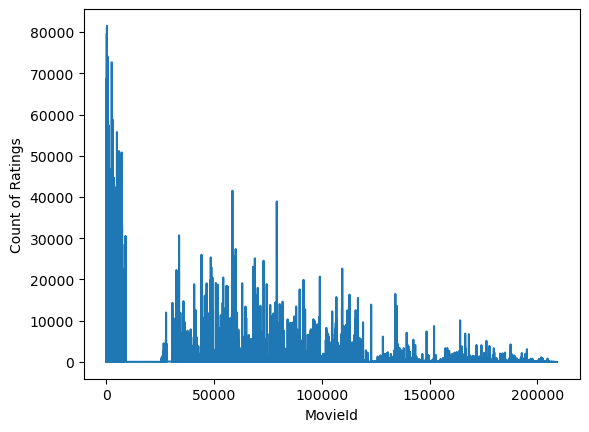

In [13]:
# testing how many ratings each movie has
ratings_distirbution = df_ratings_ratings.groupby("movieId").count()
ratings_distirbution = ratings_distirbution.reset_index()
plt.plot(ratings_distirbution["movieId"], ratings_distirbution["userId"])
plt.xlabel("MovieId")
plt.ylabel("Count of Ratings")

In [14]:
# filtering for movies with over 10 ratings
ratings_count = df_ratings_ratings.groupby("movieId")["rating"].count()
movies_with_10_plus_ratings = ratings_count[ratings_count > 10].index
filtered_ratings = df_ratings_ratings[df_ratings_ratings["movieId"].isin(movies_with_10_plus_ratings)].copy()

# taking the mean of each movie's rating
mean_ratings = filtered_ratings.groupby("movieId").mean()

# making the mean of each movie's rating an increment of 0.5
# mean_ratings["rating"] = filtered_ratings["rating"].apply(lambda x: round(x*2)/2)
mean_ratings = mean_ratings.reset_index()

In [15]:
# further cleaning of the ratings dataset is required before merging to the movies metadata
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 14073 unique movies in our movies dataset that have ratings given by the found dataset.


In [16]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [17]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

In [18]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones -> Jake added, below, cleaning of the genres to avoid redundancy
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# making every genre's text uniform to assess unique genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.lower()

# removing redundant verbiage for genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" movies", "")

# fixing some genres being as lists
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].map(str)
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("[", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("]", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("'", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace('"', "")

In [19]:
# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [20]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones -> Jake added further cleaning of genres before choosing the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.lower()

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].map(str)
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("[", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("]", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("'", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace('"', "")

df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# cleaning the single genre movies' genres
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.lower()

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" film", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("[", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("]", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("'", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace('"', "")

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

The mean number of countries of a given movie is:  2


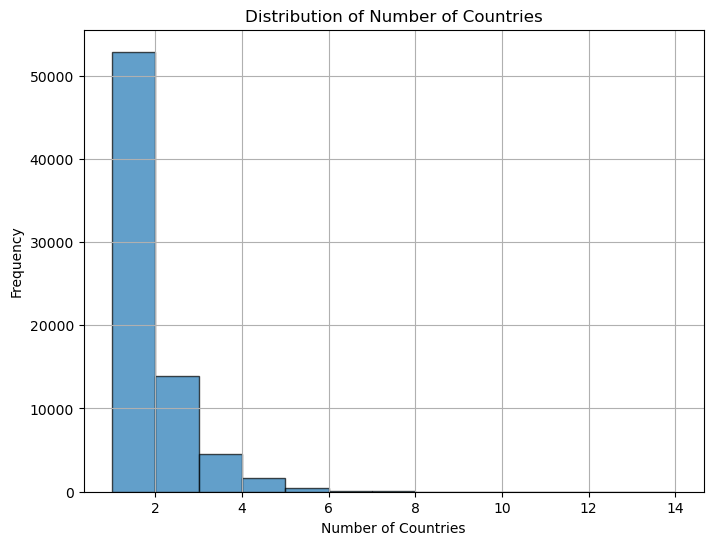

In [21]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Countries')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')
plt.grid(True)

In [22]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [23]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [24]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

In [25]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 13889 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


In [26]:
# deleting not used dataframes (but keeping the original ones)
del df_movies_tmdb
del df_movies_tmdb_ratings_exploded
del df_movies_tmdb_ratings_multi
del df_ratings_linked

### Adding `region` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by production region.

In [27]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

## Defining a master movies dataset
`df_movies_tmdb_ratings` is now one of the master dataframes. Since two columns have been exploded (`genres`, `revenues`) statistics might have been altered. Therefore, a smaller dataframe containing only unique titles must be defined to analyze features such as `revenue` or the ratings-related ones. Unique titles rows with the smallest amount of missing values among columns will be selected. This final master dataframe is `df_movies_tmdb_ratings_unique`.

In [28]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

# Historical Proximity Score

Creation of a dataframe with indexes

In [29]:
# column index
unique_release_dates = sorted(df_movies_tmdb_ratings['release_date'].unique())

# row index
unique_countries = df_movies_tmdb_ratings['countries'].unique()

# Dataframe creation
historical_proximity_score = pd.DataFrame(index=unique_countries, columns=unique_release_dates)

# empty initial dataframe
historical_proximity_score[:] = 0

The dataframe must be filled manually. Entries are in range from -1 to 1. 
Taking into account that a movie takes minimum a year to produce (in general), if a meaningful historical event happens, a score of 1 is given to the exact year of the event and the year later, then the score lowers by 0.2 each year. Therefore, an historical event has a decreasing impact on movies for the next 5 years. If the event is positive, the score is positive, viceversa if the event is negative. Events for each country are asked to ChatGPT.

In [30]:
country = 'United States of America'
events = [
    {"release_date": 1898, "event": "Spanish-American War", "score": 0.7},
    {"release_date": 1913, "event": "Founding of the Federal Reserve", "score": 0.5},
    {"release_date": 1920, "event": "Ratification of the 19th Amendment", "score": 1},
    {"release_date": 1929, "event": "Wall Street Crash", "score": -1},
    {"release_date": 1941, "event": "Pearl Harbor Attack", "score": -1},
    {"release_date": 1945, "event": "End of World War II", "score": 1},
    {"release_date": 1969, "event": "Moon Landing", "score": 1},
    {"release_date": 1975, "event": "End of Vietnam War", "score": -0.7},
    {"release_date": 1974, "event": "Watergate Scandal and Nixon's Resignation", "score": -1},
    {"release_date": 1989, "event": "Fall of the Berlin Wall", "score": 1},
    {"release_date": 1991, "event": "End of the Cold War", "score": 1},
    {"release_date": 1990, "event": "Gulf War", "score": -0.6},
    {"release_date": 1998, "event": "Clinton Impeachment", "score": -0.5},
    {"release_date": 2001, "event": "9/11 Terrorist Attacks", "score": -1},
    {"release_date": 2008, "event": "Global Financial Crisis", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Israel'
events = [
    {"release_date": 1882, "event": "First Aliyah", "score": 0.8},
    {"release_date": 1904, "event": "Second Aliyah", "score": 0.7},
    {"release_date": 1909, "event": "Founding of Tel Aviv", "score": 0.9},
    {"release_date": 1917, "event": "Balfour Declaration", "score": 1},
    {"release_date": 1929, "event": "Arab Riots", "score": -0.8},
    {"release_date": 1947, "event": "UN Partition Plan", "score": 1},
    {"release_date": 1948, "event": "Israeli Independence", "score": 1},
    {"release_date": 1948, "event": "1948 Arab-Israeli War", "score": 1},
    {"release_date": 1956, "event": "Suez Crisis", "score": 0.5},
    {"release_date": 1967, "event": "Six-Day War", "score": 1},
    {"release_date": 1973, "event": "Yom Kippur War", "score": -1},
    {"release_date": 1978, "event": "Camp David Accords", "score": 1},
    {"release_date": 1982, "event": "Lebanon War", "score": -0.5},
    {"release_date": 1987, "event": "First Intifada", "score": -0.8},
    {"release_date": 1993, "event": "Oslo Accords", "score": 1},
    {"release_date": 2000, "event": "Second Intifada", "score": -1},
    {"release_date": 2005, "event": "Disengagement from Gaza", "score": 0.7},
    {"release_date": 2006, "event": "2006 Lebanon War", "score": -0.6},
    {"release_date": 2008, "event": "Gaza War (Operation Cast Lead)", "score": -1},
    {"release_date": 2010, "event": "Arab Spring", "score": 0.5},
    {"release_date": 2012, "event": "Operation Pillar of Defense", "score": -0.5},  # An IDF operation in Gaza

]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Australia'
events = [
    {"release_date": 1901, "event": "Foundation of the Commonwealth of Australia", "score": 1},
    {"release_date": 1914, "event": "Australia's First World War Contribution", "score": -1},
    {"release_date": 1917, "event": "The Eureka Rebellion", "score": 0.8},
    {"release_date": 1929, "event": "The Great Depression", "score": -1},
    {"release_date": 1939, "event": "Australia's Entry into World War II", "score": -1},
    {"release_date": 1942, "event": "The Fall of Singapore", "score": -1},
    {"release_date": 1945, "event": "Post-War Immigration", "score": 0.8},
    {"release_date": 1967, "event": "1967 Referendum", "score": 1},
    {"release_date": 1969, "event": "Vietnam War", "score": -0.8},
    {"release_date": 1972, "event": "Whitlam Government", "score": 1},
    {"release_date": 1975, "event": "The 1975 Constitutional Crisis", "score": -1},
    {"release_date": 1988, "event": "Bicentenary Celebrations", "score": 0.5},
    {"release_date": 1992, "event": "Mabo Decision", "score": 1},
    {"release_date": 2001, "event": "The Tampa Affair", "score": -0.8},
    {"release_date": 2003, "event": "The Iraq War", "score": -1},
    {"release_date": 2007, "event": "National Apology to Indigenous Australians", "score": 1},
    {"release_date": 2008, "event": "Global Financial Crisis", "score": -1},
    {"release_date": 2010, "event": "Australian Political Instability", "score": -0.5},
    {"release_date": 2012, "event": "Australia’s Carbon Tax", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'France'
events = [
    {"release_date": 1894, "event": "The Dreyfus Affair", "score": -0.8},
    {"release_date": 1914, "event": "World War I", "score": -1},
    {"release_date": 1919, "event": "Treaty of Versailles", "score": 0.9},
    {"release_date": 1936, "event": "The Popular Front", "score": 0.8},
    {"release_date": 1939, "event": "World War II", "score": -1},
    {"release_date": 1944, "event": "French Liberation", "score": 1},
    {"release_date": 1946, "event": "Indochina War", "score": -1},
    {"release_date": 1954, "event": "End of French Colonial Rule in Indochina", "score": 0.7},
    {"release_date": 1958, "event": "The Fifth Republic", "score": 1},
    {"release_date": 1968, "event": "May 1968 Protests", "score": -0.5},
    {"release_date": 1981, "event": "Election of François Mitterrand", "score": 1},
    {"release_date": 1989, "event": "Fall of the Berlin Wall", "score": 1},
    {"release_date": 1990, "event": "Gulf War", "score": -0.8},
    {"release_date": 1992, "event": "Maastricht Treaty", "score": 1},
    {"release_date": 2001, "event": "September 11 Attacks", "score": -1},
    {"release_date": 2005, "event": "French Riots", "score": -1},
    {"release_date": 2008, "event": "Global Financial Crisis", "score": -1},
    {"release_date": 2010, "event": "Pension Reforms", "score": -0.7},
    {"release_date": 2011, "event": "NATO Intervention in Libya", "score": 0.8},
    {"release_date": 2012, "event": "French Presidential Election (Hollande)", "score": 1},
]


# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Hungary'
events = [
    {"release_date": 1914, "event": "World War I", "score": -1},
    {"release_date": 1920, "event": "Treaty of Trianon", "score": -1},
    {"release_date": 1944, "event": "Hungary's WWII Alignment with Nazi Germany", "score": -1},
    {"release_date": 1945, "event": "End of WWII and Soviet Occupation", "score": -1},
    {"release_date": 1956, "event": "Hungarian Revolution", "score": -1},
    {"release_date": 1968, "event": "Economic Reforms (New Economic Mechanism)", "score": 0.5},
    {"release_date": 1989, "event": "Democratic Transition", "score": 1},
    {"release_date": 1990, "event": "First Free Elections", "score": 1},
    {"release_date": 1999, "event": "Hungary Joins NATO", "score": 1},
    {"release_date": 2004, "event": "Hungary Joins the European Union", "score": 1},
    {"release_date": 2006, "event": "Hungarian Riots", "score": -1},
    {"release_date": 2008, "event": "Global Financial Crisis", "score": -1},
    {"release_date": 2010, "event": "2010 Parliamentary Elections", "score": 1},
    {"release_date": 2011, "event": "New Constitution and Controversy", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Netherlands'
events = [
    {"release_date": 1914, "event": "World War I", "score": -1},
    {"release_date": 1917, "event": "Suffrage Reform (Universal Male Suffrage)", "score": 0.7},
    {"release_date": 1940, "event": "German Occupation in World War II", "score": -1},
    {"release_date": 1944, "event": "Hunger Winter", "score": -1},
    {"release_date": 1945, "event": "Liberation from Nazi Occupation", "score": 1},
    {"release_date": 1949, "event": "Independence of Indonesia", "score": -0.9},
    {"release_date": 1973, "event": "Oil Crisis", "score": -0.8},
    {"release_date": 1980, "event": "Dutch Civil Rights Movements", "score": 0.6},
    {"release_date": 1992, "event": "Maastricht Treaty and EU Formation", "score": 1},
    {"release_date": 2001, "event": "9/11 Attacks and War on Terror", "score": -1},
    {"release_date": 2002, "event": "Assassination of Pim Fortuyn", "score": -1},
    {"release_date": 2008, "event": "Global Financial Crisis", "score": -1},
    {"release_date": 2010, "event": "Dutch General Election and Austerity", "score": -0.8},
    {"release_date": 2012, "event": "Rise of Geert Wilders and the PVV", "score": 0.5},
]


# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'United Kingdom'
events = [
    {"release_date": 1914, "event": "World War I", "score": -1},
    {"release_date": 1918, "event": "Suffragette Movement and Women Gain the Vote", "score": 1},
    {"release_date": 1929, "event": "The Great Depression", "score": -1},
    {"release_date": 1940, "event": "German Blitz and World War II", "score": -1},
    {"release_date": 1945, "event": "Victory in WWII and Post-War Reconstruction", "score": 1},
    {"release_date": 1947, "event": "Independence of India", "score": -0.9},
    {"release_date": 1948, "event": "NHS Establishment", "score": 1},
    {"release_date": 1956, "event": "The Suez Crisis", "score": -1},
    {"release_date": 1963, "event": "The Profumo Affair", "score": -1},
    {"release_date": 1979, "event": "Winter of Discontent and Election of Margaret Thatcher", "score": -0.8},
    {"release_date": 1982, "event": "Falklands War", "score": 1},
    {"release_date": 1990, "event": "End of the Thatcher Era", "score": 0.5},
    {"release_date": 1998, "event": "Good Friday Agreement (End of The Troubles)", "score": 1},
    {"release_date": 2001, "event": "9/11 Attacks and War on Terror", "score": -1},
    {"release_date": 2005, "event": "London Bombings", "score": -1},
    {"release_date": 2008, "event": "Global Financial Crisis", "score": -1},
    {"release_date": 2010, "event": "2010 General Election and Coalition Government", "score": 0.5},
    {"release_date": 2011, "event": "England Riots", "score": -0.8},
    {"release_date": 2012, "event": "London Olympics", "score": 1},
]


# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'New Zealand'
events = [
    {"release_date": 1893, "event": "Women Gain the Vote", "score": 1},
    {"release_date": 1929, "event": "The Great Depression", "score": -1},
    {"release_date": 1939, "event": "New Zealand Joins World War II", "score": -1},
    {"release_date": 1947, "event": "Post-War Economic Rebuilding", "score": 0.7},
    {"release_date": 1953, "event": "First Official Māori Language Week", "score": 0.6},
    {"release_date": 1973, "event": "Oil Crisis", "score": -0.8},
    {"release_date": 1981, "event": "Springbok Rugby Tour and Anti-Apartheid Protests", "score": -0.9},
    {"release_date": 1984, "event": "Nuclear-Free Zone Declared", "score": 1},
    {"release_date": 1987, "event": "Stock Market Crash", "score": -1},
    {"release_date": 1990, "event": "Māori Treaty Settlements Begin", "score": 0.8},
    {"release_date": 2001, "event": "9/11 Attacks and Support for War on Terror", "score": -1},
    {"release_date": 2005, "event": "Labour Party Wins Third Term", "score": 0.6},
    {"release_date": 2008, "event": "Global Financial Crisis", "score": -1},
    {"release_date": 2010, "event": "Christchurch Earthquake", "score": -1},
    {"release_date": 2011, "event": "New Zealand Wins Rugby World Cup", "score": 1},
    {"release_date": 2012, "event": "State Visit by Queen Elizabeth II", "score": 0.5},
]


# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'South Africa'
events = [
    {"release_date": 1886, "event": "Discovery of Gold in Witwatersrand", "score": 1},
    {"release_date": 1899, "event": "Anglo-Boer War", "score": -1},
    {"release_date": 1910, "event": "Formation of Union of South Africa", "score": 0.8},
    {"release_date": 1948, "event": "Implementation of Apartheid", "score": -1},
    {"release_date": 1960, "event": "Sharpeville Massacre", "score": -1},
    {"release_date": 1964, "event": "Rivonia Trial and Mandela's Imprisonment", "score": -1},
    {"release_date": 1976, "event": "Soweto Uprising", "score": -1},
    {"release_date": 1990, "event": "Release of Nelson Mandela", "score": 1},
    {"release_date": 1994, "event": "First Democratic Elections", "score": 1},
    {"release_date": 2001, "event": "World Conference Against Racism", "score": 0.7},
    {"release_date": 2003, "event": "South Africa Hosts Cricket World Cup", "score": 0.6},
    {"release_date": 2006, "event": "HIV/AIDS Awareness and Treatment Programs", "score": -0.5},
    {"release_date": 2010, "event": "South Africa Hosts FIFA World Cup", "score": 1},
    {"release_date": 2012, "event": "Nelson Mandela's Health Issues", "score": -0.5},
]


# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Spain'
events = [
    {"release_date": 1898, "event": "Spanish-American War", "score": -1},
    {"release_date": 1931, "event": "Proclamation of the Second Spanish Republic", "score": 0.8},
    {"release_date": 1936, "event": "Spanish Civil War Begins", "score": -1},
    {"release_date": 1939, "event": "End of Spanish Civil War - Franco's Dictatorship Begins", "score": -1},
    {"release_date": 1975, "event": "Death of Francisco Franco and Transition to Democracy", "score": 1},
    {"release_date": 1981, "event": "1981 Attempted Military Coup (23-F)", "score": -0.7},
    {"release_date": 1986, "event": "Spain Joins the European Economic Community (EEC)", "score": 1},
    {"release_date": 1992, "event": "Barcelona Olympics and Expo 92 in Seville", "score": 1},
    {"release_date": 2004, "event": "Madrid Train Bombings (3/11)", "score": -1},
    {"release_date": 2008, "event": "Global Financial Crisis Hits Spain", "score": -0.8},
    {"release_date": 2010, "event": "Spanish Economic Recession and Austerity Measures", "score": -1},
    {"release_date": 2011, "event": "Indignados Movement (Anti-Austerity Protests)", "score": -0.5},
    {"release_date": 2012, "event": "Catalan Independence Referendum (Not Official)", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Canada'
events = [
    {"release_date": 1896, "event": "The Klondike Gold Rush", "score": 1},
    {"release_date": 1914, "event": "Canada Enters World War I", "score": -1},
    {"release_date": 1917, "event": "The Battle of Vimy Ridge", "score": 0.8},
    {"release_date": 1931, "event": "Statute of Westminster - Full Legislative Independence from Britain", "score": 1},
    {"release_date": 1939, "event": "Canada Enters World War II", "score": -1},
    {"release_date": 1949, "event": "Canada Joins NATO", "score": 1},
    {"release_date": 1967, "event": "Introduction of the Canadian Multiculturalism Act", "score": 1},
    {"release_date": 1982, "event": "Canada Act (Constitution Act) - Full Constitutional Independence from the UK", "score": 1},
    {"release_date": 1995, "event": "Quebec Referendum on Sovereignty", "score": -0.8},
    {"release_date": 2001, "event": "Canada's Role in Afghanistan War", "score": -1},
    {"release_date": 2008, "event": "Apology to Indigenous Peoples for Residential Schools", "score": 1},
    {"release_date": 2011, "event": "Canada Withdraws from Kyoto Protocol", "score": -0.5},
    {"release_date": 2012, "event": "Canada Celebrates 150th Anniversary of Confederation (2017, preparations start)", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Russia'
events = [
    {"release_date": 1905, "event": "First Russian Revolution", "score": -1},
    {"release_date": 1917, "event": "Russian Revolution - October Revolution", "score": 1},
    {"release_date": 1922, "event": "Formation of the Soviet Union", "score": 1},
    {"release_date": 1941, "event": "Germany Invades the Soviet Union - Start of WWII on Eastern Front", "score": -1},
    {"release_date": 1945, "event": "End of World War II", "score": 1},
    {"release_date": 1953, "event": "Death of Joseph Stalin", "score": 0.8},
    {"release_date": 1961, "event": "Yuri Gagarin Becomes the First Human in Space", "score": 1},
    {"release_date": 1991, "event": "Collapse of the Soviet Union - Formation of the Russian Federation", "score": 1},
    {"release_date": 1999, "event": "Vladimir Putin Becomes Acting President", "score": 0.8},
    {"release_date": 2004, "event": "Second Chechen War Ends", "score": -0.7},
    {"release_date": 2008, "event": "Russia Invades Georgia (Russo-Georgian War)", "score": -1},
    {"release_date": 2010, "event": "2010 Russian Wildfires", "score": -0.5},
    {"release_date": 2012, "event": "Russian Presidential Election - Putin Returns to Power", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Romania'
events = [
    {"release_date": 1916, "event": "Romania Enters World War I", "score": -1},
    {"release_date": 1918, "event": "Union of Transylvania with Romania", "score": 1},
    {"release_date": 1939, "event": "Romania Enters World War II", "score": -1},
    {"release_date": 1947, "event": "King Michael I Forced to Abdicate - Establishment of Communist Regime", "score": -1},
    {"release_date": 1965, "event": "Nicolae Ceaușescu Becomes General Secretary of the Romanian Communist Party", "score": 0.5},
    {"release_date": 1989, "event": "Romanian Revolution and Execution of Nicolae Ceaușescu", "score": 1},
    {"release_date": 2004, "event": "Romania Joins NATO", "score": 1},
    {"release_date": 2007, "event": "Romania Joins the European Union", "score": 1},
    {"release_date": 2009, "event": "Romanian Economic Crisis", "score": -0.8},
    {"release_date": 2012, "event": "Political Crisis - Suspension of President Basescu", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Japan'
events = [
    {"release_date": 1894, "event": "First Sino-Japanese War", "score": 1},
    {"release_date": 1904, "event": "Russo-Japanese War", "score": 1},
    {"release_date": 1912, "event": "Meiji Era Ends - Taisho Era Begins", "score": 0.8},
    {"release_date": 1931, "event": "Japanese Invasion of Manchuria", "score": -1},
    {"release_date": 1937, "event": "Second Sino-Japanese War Begins", "score": -1},
    {"release_date": 1941, "event": "Attack on Pearl Harbor - Japan Enters World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Japan Surrenders", "score": 1},
    {"release_date": 1952, "event": "Treaty of Peace with Japan - US Occupation Ends", "score": 1},
    {"release_date": 1964, "event": "Tokyo Olympics", "score": 1},
    {"release_date": 1989, "event": "Emperor Hirohito Dies - Emperor Akihito Becomes Emperor", "score": 0.8},
    {"release_date": 1995, "event": "Great Hanshin Earthquake", "score": -0.8},
    {"release_date": 2011, "event": "Great East Japan Earthquake and Tsunami", "score": -1},
    {"release_date": 2012, "event": "Japan's Economy Shows Signs of Stagnation", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'China'
events = [
    {"release_date": 1895, "event": "First Sino-Japanese War Ends - Treaty of Shimonoseki", "score": -1},
    {"release_date": 1911, "event": "Xinhai Revolution - End of Qing Dynasty", "score": 1},
    {"release_date": 1927, "event": "Chinese Civil War Begins", "score": -1},
    {"release_date": 1937, "event": "Second Sino-Japanese War Begins", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Japan Surrenders", "score": 1},
    {"release_date": 1949, "event": "People's Republic of China Established", "score": 1},
    {"release_date": 1959, "event": "Tibetan Uprising Against Chinese Rule", "score": -1},
    {"release_date": 1966, "event": "Cultural Revolution Begins", "score": -1},
    {"release_date": 1976, "event": "Death of Mao Zedong - End of the Cultural Revolution", "score": 0.8},
    {"release_date": 1989, "event": "Tiananmen Square Massacre", "score": -1},
    {"release_date": 2001, "event": "China Joins the World Trade Organization (WTO)", "score": 1},
    {"release_date": 2008, "event": "Beijing Olympics", "score": 1},
    {"release_date": 2010, "event": "China Becomes the World's Second Largest Economy", "score": 1},
    {"release_date": 2012, "event": "Xi Jinping Becomes President", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Hong Kong'
events = [
    {"release_date": 1898, "event": "Second Convention of Peking - Lease of Hong Kong to Britain for 99 Years", "score": 1},
    {"release_date": 1941, "event": "Japanese Occupation of Hong Kong During World War II", "score": -1},
    {"release_date": 1945, "event": "End of Japanese Occupation - Hong Kong Returns to British Rule", "score": 1},
    {"release_date": 1967, "event": "Hong Kong Riots - Leftist Protests", "score": -0.8},
    {"release_date": 1984, "event": "Sino-British Joint Declaration - Hong Kong's Handover to China in 1997", "score": 1},
    {"release_date": 1997, "event": "Hong Kong Handover to China - End of British Rule", "score": 1},
    {"release_date": 2003, "event": "2003 Anti-Extradition Protests", "score": -0.8},
    {"release_date": 2008, "event": "Hong Kong Hosts the Asia-Pacific Economic Cooperation (APEC) Summit", "score": 0.8},
    {"release_date": 2014, "event": "Umbrella Movement - Pro-Democracy Protests", "score": -1},
    {"release_date": 2019, "event": "Anti-Extradition Protests", "score": -1},
    {"release_date": 2012, "event": "Introduction of Moral and National Education Controversy", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Germany'
events = [
    {"release_date": 1914, "event": "Germany Enters World War I", "score": -1},
    {"release_date": 1918, "event": "End of World War I - German Revolution", "score": -1},
    {"release_date": 1933, "event": "Adolf Hitler Becomes Chancellor", "score": -1},
    {"release_date": 1939, "event": "Germany Invades Poland - Start of World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Germany Surrenders", "score": 1},
    {"release_date": 1949, "event": "Formation of East and West Germany", "score": 1},
    {"release_date": 1961, "event": "Construction of the Berlin Wall", "score": -1},
    {"release_date": 1989, "event": "Fall of the Berlin Wall", "score": 1},
    {"release_date": 1990, "event": "Reunification of Germany", "score": 1},
    {"release_date": 2002, "event": "Introduction of the Euro in Germany", "score": 1},
    {"release_date": 2005, "event": "Angela Merkel Becomes Chancellor of Germany", "score": 0.8},
    {"release_date": 2008, "event": "Global Financial Crisis Affects Germany", "score": -0.8},
    {"release_date": 2011, "event": "Germany's Decision to Phase Out Nuclear Energy (Post-Fukushima)", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'West Germany'
events = [
    {"release_date": 1949, "event": "Formation of West Germany", "score": 1},
    {"release_date": 1950, "event": "West Germany Joins the Council of Europe", "score": 0.8},
    {"release_date": 1955, "event": "West Germany Joins NATO", "score": 1},
    {"release_date": 1961, "event": "Construction of the Berlin Wall", "score": -1},
    {"release_date": 1969, "event": "Willy Brandt Becomes Chancellor - Ostpolitik Begins", "score": 0.8},
    {"release_date": 1972, "event": "West Germany and East Germany Sign Basic Treaty", "score": 1},
    {"release_date": 1989, "event": "Fall of the Berlin Wall", "score": 1},
    {"release_date": 1990, "event": "Reunification of Germany", "score": 1},
    {"release_date": 1991, "event": "End of the Cold War - The Soviet Union Collapses", "score": 1},
    {"release_date": 1992, "event": "Maastricht Treaty - West Germany Becomes Part of the European Union", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Italy'
events = [
    {"release_date": 1889, "event": "Foundation of the Italian Socialist Party", "score": 0.8},
    {"release_date": 1915, "event": "Italy Enters World War I", "score": -1},
    {"release_date": 1922, "event": "Mussolini Becomes Prime Minister - Fascist Regime Begins", "score": -1},
    {"release_date": 1935, "event": "Italy Invades Ethiopia", "score": -1},
    {"release_date": 1939, "event": "Italy Enters World War II", "score": -1},
    {"release_date": 1943, "event": "Italy Surrenders in World War II - Mussolini is Overthrown", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Italy Liberated", "score": 1},
    {"release_date": 1946, "event": "Italian Republic Established - End of Monarchy", "score": 1},
    {"release_date": 1947, "event": "Treaty of Peace with Italy - Italy Loses Colonies", "score": -1},
    {"release_date": 1949, "event": "Italy Joins NATO", "score": 1},
    {"release_date": 1957, "event": "Treaty of Rome - Founding of the European Economic Community (EEC)", "score": 1},
    {"release_date": 1960, "event": "Economic Miracle - Rapid Economic Growth", "score": 1},
    {"release_date": 1969, "event": "Hot Autumn - Labour Strikes and Social Unrest", "score": -0.8},
    {"release_date": 1970, "event": "Introduction of the Italian Constitution", "score": 0.8},
    {"release_date": 1980, "event": "Murder of Aldo Moro - Rise of Terrorism in Italy", "score": -1},
    {"release_date": 1990, "event": "1990 FIFA World Cup in Italy", "score": 0.8},
    {"release_date": 1992, "event": "Mani Pulite Anti-Corruption Investigation", "score": -0.8},
    {"release_date": 2000, "event": "Italy Hosts the G8 Summit", "score": 0.8},
    {"release_date": 2002, "event": "Italy Adopts the Euro", "score": 1},
    {"release_date": 2005, "event": "Italian Referendum on Constitutional Reforms", "score": -0.5},
    {"release_date": 2009, "event": "L'Aquila Earthquake", "score": -0.8},
    {"release_date": 2011, "event": "Italy in the Eurozone Debt Crisis", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'India'
events = [
    {"release_date": 1885, "event": "Indian National Congress Founded", "score": 0.8},
    {"release_date": 1919, "event": "Jallianwala Bagh Massacre", "score": -1},
    {"release_date": 1920, "event": "Non-Cooperation Movement Led by Gandhi", "score": 0.8},
    {"release_date": 1930, "event": "Salt March - Civil Disobedience Movement", "score": 0.8},
    {"release_date": 1942, "event": "Quit India Movement", "score": 0.5},
    {"release_date": 1947, "event": "Indian Independence - Partition of India and Pakistan", "score": 1},
    {"release_date": 1950, "event": "Adoption of the Indian Constitution", "score": 1},
    {"release_date": 1956, "event": "Formation of Indian States Based on Language", "score": 0.8},
    {"release_date": 1962, "event": "India-China War", "score": -1},
    {"release_date": 1965, "event": "India-Pakistan War", "score": -1},
    {"release_date": 1971, "event": "India-Pakistan War - Creation of Bangladesh", "score": 1},
    {"release_date": 1974, "event": "India's First Nuclear Test (Smiling Buddha)", "score": 0.8},
    {"release_date": 1984, "event": "Operation Blue Star - Sikh Militancy in Punjab", "score": -1},
    {"release_date": 1991, "event": "Economic Liberalization - India Opens Up Economy", "score": 1},
    {"release_date": 1992, "event": "Babri Masjid Demolition - Rise of Hindu Nationalism", "score": -0.8},
    {"release_date": 2001, "event": "Gujarat Earthquake", "score": -0.8},
    {"release_date": 2002, "event": "India-Pakistan Border Tensions - Kargil War Aftermath", "score": -0.5},
    {"release_date": 2008, "event": "Mumbai Terror Attacks", "score": -1},
    {"release_date": 2010, "event": "India Hosts Commonwealth Games", "score": 0.8},
    {"release_date": 2012, "event": "Delhi Gang Rape Incident - Protests for Women's Rights", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Belgium'
events = [
    {"release_date": 1890, "event": "King Leopold II's Personal Rule in the Congo", "score": -1},
    {"release_date": 1914, "event": "Belgium Enters World War I", "score": -1},
    {"release_date": 1919, "event": "Treaty of Versailles - Belgium Gains Control of Rwanda and Burundi", "score": 0.8},
    {"release_date": 1940, "event": "German Invasion of Belgium in World War II", "score": -1},
    {"release_date": 1944, "event": "Belgium Liberated by Allied Forces", "score": 1},
    {"release_date": 1958, "event": "Brussels World Expo", "score": 0.8},
    {"release_date": 1960, "event": "Belgium Grants Independence to Congo", "score": 0.5},
    {"release_date": 1970, "event": "Belgium's First Federal Reforms", "score": 0.8},
    {"release_date": 1989, "event": "Fall of the Berlin Wall - Belgium's Role in European Integration", "score": 1},
    {"release_date": 1993, "event": "Belgium Becomes a Federal State", "score": 1},
    {"release_date": 2000, "event": "Belgium Hosts European Football Championship", "score": 0.8},
    {"release_date": 2002, "event": "Belgium Hosts the World Expo", "score": 0.8},
    {"release_date": 2006, "event": "Belgium Holds the EU Presidency", "score": 1},
    {"release_date": 2010, "event": "Belgium Goes 541 Days Without a Government", "score": -0.8},
    {"release_date": 2012, "event": "Belgium Hosts the NATO Summit", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'South Korea'
events = [
    {"release_date": 1910, "event": "Annexation of Korea by Japan", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Liberation from Japan", "score": 1},
    {"release_date": 1948, "event": "Establishment of the Republic of Korea", "score": 1},
    {"release_date": 1950, "event": "Korean War Begins", "score": -1},
    {"release_date": 1953, "event": "Korean War Ends - Armistice Agreement", "score": 0.8},
    {"release_date": 1960, "event": "April 19 Revolution - Overthrow of President Syngman Rhee", "score": 1},
    {"release_date": 1961, "event": "Military Coup by Park Chung-hee", "score": -0.8},
    {"release_date": 1972, "event": "Yushin Constitution - Strengthening of Authoritarian Rule", "score": -1},
    {"release_date": 1980, "event": "Gwangju Uprising", "score": -1},
    {"release_date": 1987, "event": "June Democratic Uprising - End of Authoritarian Rule", "score": 1},
    {"release_date": 1992, "event": "Kim Young-sam Becomes President - First Civilian President in 30 Years", "score": 1},
    {"release_date": 1997, "event": "Asian Financial Crisis - South Korea Receives IMF Bailout", "score": -0.8},
    {"release_date": 2000, "event": "First Inter-Korean Summit between Kim Dae-jung and Kim Jong-il", "score": 1},
    {"release_date": 2002, "event": "South Korea Hosts the FIFA World Cup (co-hosted with Japan)", "score": 1},
    {"release_date": 2008, "event": "Lee Myung-bak Becomes President - Economic Reforms", "score": 0.8},
    {"release_date": 2012, "event": "Park Geun-hye Elected as First Female President of South Korea", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Uruguay'
events = [
    {"release_date": 1903, "event": "The Battle of Cerrito - End of the Guerra Civil (Civil War)", "score": 1},
    {"release_date": 1917, "event": "Uruguay Enters World War I", "score": -0.5},
    {"release_date": 1933, "event": "The 1933 Coup d'état - Beginning of the Civic-Military Dictatorship", "score": -1},
    {"release_date": 1942, "event": "Uruguay Breaks Diplomatic Relations with the Axis Powers", "score": 1},
    {"release_date": 1950, "event": "Uruguay Wins the First FIFA World Cup", "score": 1},
    {"release_date": 1973, "event": "Military Coup - Establishment of Military Dictatorship", "score": -1},
    {"release_date": 1985, "event": "Return to Democracy - End of Military Dictatorship", "score": 1},
    {"release_date": 1999, "event": "Uruguay Joins the MERCOSUR Trade Bloc", "score": 1},
    {"release_date": 2005, "event": "Tabaré Vázquez Becomes President - First Left-Wing Government", "score": 1},
    {"release_date": 2010, "event": "José Mujica Becomes President - Former Guerrilla Leader", "score": 1},
    {"release_date": 2013, "event": "Uruguay Becomes First Country to Legalize Marijuana", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Argentina'
events = [
    {"release_date": 1890, "event": "The 1890 Crisis - Economic Collapse and Political Instability", "score": -1},
    {"release_date": 1916, "event": "Hipólito Yrigoyen Becomes President - First Radical Government", "score": 0.8},
    {"release_date": 1930, "event": "First Military Coup - Overthrow of Hipólito Yrigoyen", "score": -1},
    {"release_date": 1946, "event": "Juan Perón Elected President", "score": 1},
    {"release_date": 1955, "event": "Military Coup Overthrows Perón", "score": -1},
    {"release_date": 1976, "event": "Military Dictatorship - The Dirty War", "score": -1},
    {"release_date": 1982, "event": "Falklands War with the United Kingdom", "score": -1},
    {"release_date": 1983, "event": "Return to Democracy - Raúl Alfonsín Elected President", "score": 1},
    {"release_date": 1991, "event": "Convertibility Plan - Economic Reforms Under Carlos Menem", "score": 0.5},
    {"release_date": 2001, "event": "Economic Crisis and Protests - Resignation of President De la Rúa", "score": -1},
    {"release_date": 2003, "event": "Néstor Kirchner Elected President - Beginning of Economic Recovery", "score": 1},
    {"release_date": 2005, "event": "Argentina Reaches Agreement with the IMF - Economic Stability", "score": 1},
    {"release_date": 2007, "event": "Cristina Fernández de Kirchner Elected President", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Georgia'
events = [
    {"release_date": 1918, "event": "Declaration of Independence from Soviet Russia", "score": 1},
    {"release_date": 1921, "event": "Soviet Invasion - Georgia Becomes Part of the Soviet Union", "score": -1},
    {"release_date": 1991, "event": "Restoration of Independence from the Soviet Union", "score": 1},
    {"release_date": 1992, "event": "Civil War in Georgia - Rise of Eduard Shevardnadze", "score": -1},
    {"release_date": 2003, "event": "Rose Revolution - Overthrow of President Shevardnadze", "score": 1},
    {"release_date": 2008, "event": "Russo-Georgian War - Conflict over South Ossetia", "score": -1},
    {"release_date": 2012, "event": "Georgian Parliamentary Elections - Peaceful Transfer of Power", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Poland'
events = [
    {"release_date": 1918, "event": "Poland Regains Independence After World War I", "score": 1},
    {"release_date": 1939, "event": "Germany Invades Poland - Start of World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Poland's Borders Shift", "score": 1},
    {"release_date": 1980, "event": "Solidarity Movement Founded - Beginning of Anti-Communist Resistance", "score": 1},
    {"release_date": 1989, "event": "Poland's Round Table Talks - Peaceful Transition to Democracy", "score": 1},
    {"release_date": 1999, "event": "Poland Joins NATO", "score": 1},
    {"release_date": 2004, "event": "Poland Joins the European Union", "score": 1},
    {"release_date": 2010, "event": "Plane Crash in Smolensk - Death of President Lech Kaczyński", "score": -0.8},
    {"release_date": 2011, "event": "Poland Takes Over EU Presidency", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Austria'
events = [
    {"release_date": 1914, "event": "Austria-Hungary Declares War on Serbia - Start of World War I", "score": -1},
    {"release_date": 1918, "event": "Austro-Hungarian Empire Collapses - First Austrian Republic Established", "score": 1},
    {"release_date": 1938, "event": "Anschluss - Austria is Annexed by Nazi Germany", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Austria Becomes a Republic Again", "score": 1},
    {"release_date": 1955, "event": "Austrian State Treaty - Austria Gains Full Independence", "score": 1},
    {"release_date": 1995, "event": "Austria Joins the European Union", "score": 1},
    {"release_date": 2006, "event": "Austria Hosts the Winter Olympics", "score": 0.8},
    {"release_date": 2010, "event": "Austrian Banking Crisis - Effects of the Global Financial Crisis", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Brazil'
events = [
    {"release_date": 1889, "event": "Military Coup Overthrows the Empire - Proclamation of the Republic", "score": 1},
    {"release_date": 1930, "event": "Revolution of 1930 - Getúlio Vargas Becomes President", "score": 1},
    {"release_date": 1937, "event": "Estado Novo - Vargas Establishes Dictatorship", "score": -1},
    {"release_date": 1945, "event": "Vargas Regime Overthrown - End of Estado Novo", "score": 1},
    {"release_date": 1964, "event": "Military Coup Overthrows President João Goulart - Start of Military Dictatorship", "score": -1},
    {"release_date": 1985, "event": "End of Military Dictatorship - Transition to Democracy", "score": 1},
    {"release_date": 1988, "event": "New Constitution of Brazil", "score": 1},
    {"release_date": 1992, "event": "Impeachment of President Fernando Collor de Mello", "score": -0.8},
    {"release_date": 2002, "event": "Luiz Inácio Lula da Silva Elected President", "score": 1},
    {"release_date": 2010, "event": "Dilma Rousseff Elected President - First Female President of Brazil", "score": 1},
    {"release_date": 2012, "event": "Brazil Hosts the 2014 FIFA World Cup Preparations Begin", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Soviet Union'
events = [
    {"release_date": 1917, "event": "Russian Revolution - October Revolution", "score": 1},
    {"release_date": 1922, "event": "Formation of the Soviet Union", "score": 1},
    {"release_date": 1924, "event": "Death of Lenin - Power Struggle Begins", "score": -0.8},
    {"release_date": 1939, "event": "Molotov-Ribbentrop Pact Signed - Soviet Union and Nazi Germany", "score": -1},
    {"release_date": 1941, "event": "German Invasion of the Soviet Union - Start of Eastern Front in WWII", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Soviet Union Emerges as a Superpower", "score": 1},
    {"release_date": 1953, "event": "Death of Joseph Stalin", "score": 0.8},
    {"release_date": 1957, "event": "Launch of Sputnik - First Artificial Satellite", "score": 1},
    {"release_date": 1961, "event": "Construction of the Berlin Wall", "score": -1},
    {"release_date": 1962, "event": "Cuban Missile Crisis", "score": -1},
    {"release_date": 1979, "event": "Soviet Invasion of Afghanistan", "score": -1},
    {"release_date": 1985, "event": "Mikhail Gorbachev Becomes General Secretary - Begins Reforms", "score": 0.8},
    {"release_date": 1991, "event": "Collapse of the Soviet Union - Formation of Russian Federation", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Finland'
events = [
    {"release_date": 1917, "event": "Finland Declares Independence from Russia", "score": 1},
    {"release_date": 1918, "event": "Finnish Civil War", "score": -1},
    {"release_date": 1939, "event": "Winter War - Soviet Union Invades Finland", "score": -1},
    {"release_date": 1944, "event": "Finland Signs the Moscow Armistice - End of Continuation War", "score": 0.8},
    {"release_date": 1947, "event": "Paris Peace Treaty - Finland Cedes Territory to the Soviet Union", "score": -0.8},
    {"release_date": 1955, "event": "Finland Joins the Nordic Council", "score": 1},
    {"release_date": 1975, "event": "Helsinki Accords - Finland's Role in Cold War Diplomacy", "score": 0.8},
    {"release_date": 1991, "event": "End of the Soviet Union - Finland Strengthens Ties with Western Europe", "score": 0.8},
    {"release_date": 1995, "event": "Finland Joins the European Union", "score": 1},
    {"release_date": 2000, "event": "Finland Hosts the 2000 European Union Presidency", "score": 1},
    {"release_date": 2002, "event": "Finland Adopts the Euro as its Currency", "score": 1},
    {"release_date": 2008, "event": "Finland's Economic Crisis", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Norway'
events = [
    {"release_date": 1905, "event": "Norway Gains Independence from Sweden", "score": 1},
    {"release_date": 1914, "event": "Norway Remains Neutral in World War I", "score": 0.8},
    {"release_date": 1940, "event": "German Invasion of Norway - Norway Occupied During World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Norway Liberated", "score": 1},
    {"release_date": 1949, "event": "Norway Joins NATO", "score": 1},
    {"release_date": 1960, "event": "Norway Joins the European Free Trade Association (EFTA)", "score": 0.8},
    {"release_date": 1972, "event": "Norway Rejects Joining the European Economic Community (EEC) in Referendum", "score": -0.5},
    {"release_date": 1994, "event": "Norway Rejects EU Membership in a Referendum", "score": -0.8},
    {"release_date": 1999, "event": "Norway Hosts the 1999 World Ice Hockey Championship", "score": 0.8},
    {"release_date": 2005, "event": "Oil and Gas Revenue Fuels Economic Growth", "score": 1},
    {"release_date": 2011, "event": "Norway's Economic Recovery from the Global Financial Crisis", "score": 0.8},
    {"release_date": 2012, "event": "Norway Becomes World’s Richest Nation (Per Capita)", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Cuba'
events = [
    {"release_date": 1898, "event": "Spanish-American War - Cuba Gains Independence from Spain", "score": 1},
    {"release_date": 1902, "event": "Cuba Becomes a Republic", "score": 1},
    {"release_date": 1953, "event": "Fidel Castro Leads Attack on Moncada Barracks - Beginning of Cuban Revolution", "score": -1},
    {"release_date": 1959, "event": "Cuban Revolution - Fidel Castro Overthrows Batista", "score": 1},
    {"release_date": 1961, "event": "Bay of Pigs Invasion - Failed US-backed Invasion of Cuba", "score": -1},
    {"release_date": 1962, "event": "Cuban Missile Crisis - Standoff Between the US and the Soviet Union", "score": -1},
    {"release_date": 1965, "event": "Cuban Government Supports Guerrilla Movements in Latin America", "score": -0.8},
    {"release_date": 1980, "event": "Mariel Boatlift - Mass Emigration of Cubans to the United States", "score": -0.5},
    {"release_date": 1991, "event": "Collapse of the Soviet Union - Economic Crisis in Cuba", "score": -1},
    {"release_date": 2006, "event": "Fidel Castro Transfers Power to Brother Raúl Castro", "score": 0.8},
    {"release_date": 2011, "event": "Raúl Castro Begins Economic Reforms - Moves Toward Market-Oriented Changes", "score": 0.8},
    {"release_date": 2014, "event": "US and Cuba Re-establish Diplomatic Relations", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Ukraine'
events = [
    {"release_date": 1917, "event": "Ukrainian War of Independence - Creation of the Ukrainian People's Republic", "score": 1},
    {"release_date": 1922, "event": "Ukraine Becomes Part of the Soviet Union", "score": -1},
    {"release_date": 1932, "event": "Holodomor - Soviet Man-made Famine in Ukraine", "score": -1},
    {"release_date": 1941, "event": "Germany Invades Ukraine - Eastern Front of World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Ukraine Remains Part of the Soviet Union", "score": 1},
    {"release_date": 1954, "event": "Khrushchyov Transfers Crimea to Ukraine (Soviet Union)", "score": 0.8},
    {"release_date": 1986, "event": "Chernobyl Disaster", "score": -1},
    {"release_date": 1991, "event": "Ukraine Declares Independence from the Soviet Union", "score": 1},
    {"release_date": 2004, "event": "Orange Revolution - Protests Against Fraudulent Presidential Elections", "score": 1},
    {"release_date": 2010, "event": "Viktor Yanukovych Becomes President", "score": 0.5},
    {"release_date": 2014, "event": "Euromaidan Protests - Yanukovych Ousted, Annexation of Crimea by Russia", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Taiwan'
events = [
    {"release_date": 1895, "event": "Treaty of Shimonoseki - Taiwan Becomes a Colony of Japan", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Taiwan Returned to China from Japan", "score": 1},
    {"release_date": 1947, "event": "February 28 Incident - Uprising Against Kuomintang Rule", "score": -1},
    {"release_date": 1949, "event": "Chinese Civil War - Republic of China Government Moves to Taiwan", "score": 1},
    {"release_date": 1971, "event": "Taiwan Loses its Seat at the United Nations to the People's Republic of China", "score": -1},
    {"release_date": 1979, "event": "Taiwan Relations Act - U.S. Acknowledges One-China Policy but Maintains Relations with Taiwan", "score": 0.8},
    {"release_date": 1991, "event": "Taiwan's National Assembly Approves the Additional Articles to the Constitution Allowing Direct Elections", "score": 1},
    {"release_date": 1992, "event": "First Direct Legislative Yuan Elections", "score": 1},
    {"release_date": 1996, "event": "Taiwan Strait Crisis - Tensions with China", "score": -1},
    {"release_date": 2000, "event": "Democratic Progressive Party (DPP) Wins Presidency - Chen Shui-bian Becomes President", "score": 1},
    {"release_date": 2008, "event": "Ma Ying-jeou Becomes President - Cross-Strait Relations Improve", "score": 0.8},
    {"release_date": 2012, "event": "Second Term of Ma Ying-jeou - Economic and Political Challenges", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'England'
events = [
    {"release_date": 1888, "event": "Jack the Ripper Murders", "score": -0.8},
    {"release_date": 1914, "event": "England Enters World War I", "score": -1},
    {"release_date": 1918, "event": "End of World War I - Armistice", "score": 1},
    {"release_date": 1939, "event": "England Enters World War II", "score": -1},
    {"release_date": 1940, "event": "Battle of Britain", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Victory", "score": 1},
    {"release_date": 1952, "event": "Queen Elizabeth II Becomes Monarch", "score": 1},
    {"release_date": 1960, "event": "The Swinging Sixties - Cultural Revolution", "score": 1},
    {"release_date": 1966, "event": "England Wins the World Cup", "score": 1},
    {"release_date": 1973, "event": "England Joins the European Economic Community (EEC)", "score": 1},
    {"release_date": 1982, "event": "Falklands War", "score": -0.5},
    {"release_date": 1997, "event": "Tony Blair Becomes Prime Minister - Labour Government", "score": 0.8},
    {"release_date": 2000, "event": "Millennium Celebrations", "score": 0.8},
    {"release_date": 2005, "event": "London Bombings", "score": -1},
    {"release_date": 2012, "event": "London Olympics", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Sweden'
events = [
    {"release_date": 1905, "event": "Norway Gains Independence from Sweden", "score": -1},
    {"release_date": 1914, "event": "Sweden Remains Neutral in World War I", "score": 0.5},
    {"release_date": 1939, "event": "Sweden Remains Neutral in World War II", "score": 0.5},
    {"release_date": 1945, "event": "End of World War II", "score": 1},
    {"release_date": 1960, "event": "Sweden Joins the European Free Trade Association (EFTA)", "score": 1},
    {"release_date": 1972, "event": "Sweden Holds a Referendum on EU Membership (Vote No)", "score": -0.5},
    {"release_date": 1986, "event": "Assassination of Prime Minister Olof Palme", "score": -1},
    {"release_date": 1995, "event": "Sweden Joins the European Union (EU)", "score": 1},
    {"release_date": 2000, "event": "Sweden Hosts the 2000 Millennium Summit", "score": 0.8},
    {"release_date": 2003, "event": "Sweden Joins the Euro as Part of European Integration", "score": 0.8},
    {"release_date": 2004, "event": "Sweden Signs the Kyoto Protocol on Climate Change", "score": 0.8},
    {"release_date": 2010, "event": "Swedish General Election - First Right-Wing Government in 8 Years", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Switzerland'
events = [
    {"release_date": 1900, "event": "Switzerland Remains Neutral During World War I", "score": 0.5},
    {"release_date": 1914, "event": "Switzerland Remains Neutral During World War I", "score": 0.5},
    {"release_date": 1918, "event": "Swiss General Strike and Political Crisis", "score": -0.5},
    {"release_date": 1939, "event": "Switzerland Remains Neutral During World War II", "score": 0.5},
    {"release_date": 1945, "event": "End of World War II", "score": 1},
    {"release_date": 1963, "event": "Switzerland Joins the United Nations (UN) as Observer", "score": 0.5},
    {"release_date": 1971, "event": "Swiss Women Gain the Right to Vote", "score": 1},
    {"release_date": 1980, "event": "Switzerland Refuses to Join the European Economic Area (EEA)", "score": -0.5},
    {"release_date": 1992, "event": "Switzerland Rejects European Economic Area (EEA) Membership", "score": -0.5},
    {"release_date": 2002, "event": "Switzerland Joins the United Nations", "score": 1},
    {"release_date": 2004, "event": "Swiss Banking Secrecy Controversy", "score": -0.8},
    {"release_date": 2009, "event": "Switzerland's Economic Growth Slows Due to Global Financial Crisis", "score": -0.5},
    {"release_date": 2012, "event": "Switzerland Hosts the World Economic Forum Annual Meeting", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Ireland'
events = [
    {"release_date": 1916, "event": "Easter Rising - Irish Rebellion Against British Rule", "score": -1},
    {"release_date": 1921, "event": "Anglo-Irish Treaty - Creation of the Irish Free State", "score": 1},
    {"release_date": 1937, "event": "Constitution of Ireland Adopted - Establishment of the Republic of Ireland", "score": 1},
    {"release_date": 1949, "event": "Ireland Declares Itself a Republic", "score": 1},
    {"release_date": 1973, "event": "Ireland Joins the European Economic Community (EEC)", "score": 1},
    {"release_date": 1981, "event": "Bobby Sands Hunger Strike and Irish Republican Hunger Strikes", "score": -0.8},
    {"release_date": 1998, "event": "Good Friday Agreement - Peace Deal Between Ireland and Northern Ireland", "score": 1},
    {"release_date": 2001, "event": "Ireland Refuses the Euro Referendum - Rejection of the Treaty of Nice", "score": -0.5},
    {"release_date": 2008, "event": "Ireland Struggles with Economic Recession Due to the Global Financial Crisis", "score": -1},
    {"release_date": 2011, "event": "Ireland Receives International Bailout to Stabilize Economy", "score": -0.8},
    {"release_date": 2012, "event": "Ireland Votes in Favor of the Fiscal Compact Treaty", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Mexico'
events = [
    {"release_date": 1910, "event": "Mexican Revolution Begins", "score": -1},
    {"release_date": 1917, "event": "Constitution of Mexico Adopted", "score": 1},
    {"release_date": 1934, "event": "Lázaro Cárdenas Becomes President - Nationalization of Oil", "score": 1},
    {"release_date": 1940, "event": "Mexico Joins the Allies in World War II", "score": 1},
    {"release_date": 1968, "event": "Mexico City Olympics - Tlatelolco Massacre", "score": -1},
    {"release_date": 1985, "event": "Mexico City Earthquake", "score": -0.8},
    {"release_date": 1994, "event": "NAFTA Comes Into Effect", "score": 1},
    {"release_date": 2000, "event": "End of PRI's 71-Year Rule - Vicente Fox Becomes President", "score": 1},
    {"release_date": 2006, "event": "Mexican Drug War Intensifies", "score": -1},
    {"release_date": 2012, "event": "Enrique Peña Nieto Becomes President", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Czechoslovakia'
events = [
    {"release_date": 1918, "event": "Czechoslovakia Becomes Independent", "score": 1},
    {"release_date": 1938, "event": "Munich Agreement - Czechoslovakia Cedes Territory to Germany", "score": -1},
    {"release_date": 1939, "event": "Czechoslovakia Occupied by Nazi Germany", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Czechoslovakia Liberated", "score": 1},
    {"release_date": 1948, "event": "Communist Coup in Czechoslovakia", "score": -1},
    {"release_date": 1968, "event": "Prague Spring - Soviet Invasion of Czechoslovakia", "score": -1},
    {"release_date": 1989, "event": "Velvet Revolution - End of Communist Rule", "score": 1},
    {"release_date": 1993, "event": "Peaceful Split into Czech Republic and Slovakia", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Estonia'
events = [
    {"release_date": 1918, "event": "Estonia Declares Independence", "score": 1},
    {"release_date": 1940, "event": "Soviet Occupation of Estonia", "score": -1},
    {"release_date": 1941, "event": "Nazi Occupation of Estonia", "score": -1},
    {"release_date": 1944, "event": "Soviet Re-Occupation of Estonia", "score": -1},
    {"release_date": 1991, "event": "Restoration of Estonian Independence", "score": 1},
    {"release_date": 2004, "event": "Estonia Joins NATO and the European Union", "score": 1},
    {"release_date": 2007, "event": "Bronze Soldier Riots", "score": -0.8},
    {"release_date": 2012, "event": "Estonia Becomes a Member of the Eurozone", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Luxembourg'
events = [
    {"release_date": 1890, "event": "The Death of Grand Duke Adolphe and the Beginning of Grand Duchy under Grand Duke William IV", "score": 0.8},
    {"release_date": 1914, "event": "Germany Invades Luxembourg During World War I", "score": -1},
    {"release_date": 1919, "event": "Luxembourg Becomes a Founding Member of the League of Nations", "score": 1},
    {"release_date": 1940, "event": "German Occupation of Luxembourg During World War II", "score": -1},
    {"release_date": 1944, "event": "Liberation of Luxembourg from German Occupation", "score": 1},
    {"release_date": 1948, "event": "Luxembourg Joins the Benelux Economic Union", "score": 1},
    {"release_date": 1957, "event": "Luxembourg Becomes a Founding Member of the European Economic Community (EEC)", "score": 1},
    {"release_date": 1994, "event": "Luxembourg Becomes a Member of the European Union (EU) as Part of the Maastricht Treaty", "score": 1},
    {"release_date": 1999, "event": "Luxembourg Hosts the European Court of Justice", "score": 1},
    {"release_date": 2012, "event": "Luxembourg Celebrates its 175th Anniversary of Independence", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Denmark'
events = [
    {"release_date": 1905, "event": "Denmark Grants Home Rule to Greenland", "score": 0.8},
    {"release_date": 1914, "event": "Denmark Remains Neutral in World War I", "score": 0.5},
    {"release_date": 1918, "event": "Denmark Loses the Danish West Indies to the United States", "score": -0.8},
    {"release_date": 1940, "event": "Germany Invades Denmark During World War II", "score": -1},
    {"release_date": 1943, "event": "Denmark Rescues its Jewish Population from Nazi Occupation", "score": 1},
    {"release_date": 1949, "event": "Denmark Becomes a Member of NATO", "score": 1},
    {"release_date": 1953, "event": "New Danish Constitution Enacted", "score": 0.8},
    {"release_date": 1973, "event": "Denmark Joins the European Economic Community (EEC)", "score": 1},
    {"release_date": 1992, "event": "Denmark Rejects the Maastricht Treaty in a Referendum", "score": -0.8},
    {"release_date": 2000, "event": "Denmark Rejects the Euro in a Referendum", "score": -0.5},
    {"release_date": 2006, "event": "Denmark is a Founding Member of the Nordic Council of Ministers", "score": 0.8},
    {"release_date": 2012, "event": "Denmark Hosts the COP15 Climate Change Conference", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Iceland'
events = [
    {"release_date": 1918, "event": "Iceland Becomes a Sovereign State in a Personal Union with Denmark", "score": 0.8},
    {"release_date": 1940, "event": "British Occupation of Iceland During World War II", "score": -1},
    {"release_date": 1941, "event": "American Forces Occupy Iceland During World War II", "score": -0.8},
    {"release_date": 1944, "event": "Iceland Declares Independence from Denmark", "score": 1},
    {"release_date": 1951, "event": "Iceland Joins NATO", "score": 1},
    {"release_date": 1970, "event": "Iceland Joins the European Free Trade Association (EFTA)", "score": 0.8},
    {"release_date": 1980, "event": "Vigdís Finnbogadóttir Becomes Iceland's First Female President", "score": 1},
    {"release_date": 2008, "event": "Iceland's Financial Crisis", "score": -1},
    {"release_date": 2010, "event": "Iceland's Volcanic Eruption (Eyjafjallajökull)", "score": -0.8},
    {"release_date": 2011, "event": "Iceland's Referendum Rejects Debt Repayment Agreement", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Iran'
events = [
    {"release_date": 1905, "event": "Constitutional Revolution in Iran", "score": 1},
    {"release_date": 1914, "event": "Iran Neutral During World War I", "score": 0.5},
    {"release_date": 1921, "event": "Coup by Reza Khan - Beginning of Pahlavi Dynasty", "score": 0.8},
    {"release_date": 1941, "event": "Allied Occupation of Iran During World War II", "score": -1},
    {"release_date": 1951, "event": "Nationalization of Iranian Oil Industry - Prime Minister Mossadegh", "score": 1},
    {"release_date": 1953, "event": "CIA-backed Coup Overthrows Mossadegh - Reza Shah’s Son, Mohammad Reza Pahlavi, Restored", "score": -1},
    {"release_date": 1979, "event": "Iranian Revolution - Overthrow of Shah, Establishment of Islamic Republic", "score": 1},
    {"release_date": 1980, "event": "Iran Hostage Crisis", "score": -1},
    {"release_date": 1989, "event": "Death of Ayatollah Khomeini - Iran’s Leadership Transition", "score": 0.8},
    {"release_date": 2001, "event": "Iran Supports the U.S. Invasion of Afghanistan", "score": 0.5},
    {"release_date": 2009, "event": "2009 Iranian Presidential Election Protests", "score": -1},
    {"release_date": 2012, "event": "Iran Faces International Sanctions Over Nuclear Program", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Lebanon'
events = [
    {"release_date": 1916, "event": "Sykes-Picot Agreement - Division of Ottoman Territories", "score": -1},
    {"release_date": 1920, "event": "Creation of Greater Lebanon Under French Mandate", "score": 0.8},
    {"release_date": 1943, "event": "Lebanese Independence and Establishment of National Pact", "score": 1},
    {"release_date": 1958, "event": "Lebanese Civil War - First Phase", "score": -1},
    {"release_date": 1975, "event": "Lebanese Civil War Breaks Out", "score": -1},
    {"release_date": 1982, "event": "Israeli Invasion of Lebanon", "score": -1},
    {"release_date": 1989, "event": "Taif Agreement - End of Civil War", "score": 0.8},
    {"release_date": 2000, "event": "Israeli Withdrawal from Southern Lebanon", "score": 1},
    {"release_date": 2005, "event": "Assassination of Prime Minister Rafik Hariri - Cedar Revolution", "score": 1},
    {"release_date": 2006, "event": "2006 Lebanon War with Israel", "score": -1},
    {"release_date": 2008, "event": "Political Crisis Ends with Doha Agreement", "score": 0.5},
    {"release_date": 2011, "event": "Lebanese Civil Unrest - Arab Spring Protests", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Singapore'
events = [
    {"release_date": 1819, "event": "Foundation of Modern Singapore by Sir Stamford Raffles", "score": 1},
    {"release_date": 1942, "event": "Japanese Occupation of Singapore During World War II", "score": -1},
    {"release_date": 1959, "event": "Self-Government Granted to Singapore", "score": 1},
    {"release_date": 1963, "event": "Singapore Joins Malaysia", "score": 0.5},
    {"release_date": 1965, "event": "Singapore's Independence from Malaysia", "score": 1},
    {"release_date": 1967, "event": "Formation of the Association of Southeast Asian Nations (ASEAN)", "score": 0.8},
    {"release_date": 1971, "event": "British Military Withdrawal from Singapore", "score": 0.8},
    {"release_date": 1980, "event": "Economic Transformation Under Lee Kuan Yew's Government", "score": 1},
    {"release_date": 1990, "event": "Lee Kuan Yew Steps Down as Prime Minister, Goh Chok Tong Takes Over", "score": 0.8},
    {"release_date": 2000, "event": "Singapore Becomes a Global Financial Hub", "score": 1},
    {"release_date": 2004, "event": "Singapore Hosts the 117th International Olympic Committee Session", "score": 0.8},
    {"release_date": 2010, "event": "Singapore Becomes the World's Most Competitive Economy", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Czech Republic'
events = [
    {"release_date": 1918, "event": "Formation of Czechoslovakia", "score": 1},
    {"release_date": 1938, "event": "Munich Agreement - Czechoslovakia is Partially Divided", "score": -1},
    {"release_date": 1939, "event": "German Occupation of Czechoslovakia", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Czechoslovakia Liberated", "score": 1},
    {"release_date": 1948, "event": "Communist Coup in Czechoslovakia", "score": -1},
    {"release_date": 1968, "event": "Prague Spring - Soviet Invasion of Czechoslovakia", "score": -1},
    {"release_date": 1989, "event": "Velvet Revolution - End of Communist Rule", "score": 1},
    {"release_date": 1993, "event": "Czechoslovakia Splits - Formation of Czech Republic and Slovakia", "score": 1},
    {"release_date": 1999, "event": "Czech Republic Joins NATO", "score": 1},
    {"release_date": 2004, "event": "Czech Republic Joins the European Union", "score": 1},
    {"release_date": 2008, "event": "Czech Republic Assumes Presidency of the European Union", "score": 0.8},
    {"release_date": 2010, "event": "Czech Republic's Economic Challenges - Global Financial Crisis Impact", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Serbia'
events = [
    {"release_date": 1912, "event": "First Balkan War", "score": 1},
    {"release_date": 1913, "event": "Second Balkan War", "score": -1},
    {"release_date": 1914, "event": "Assassination of Archduke Franz Ferdinand - Start of World War I", "score": -1},
    {"release_date": 1918, "event": "Formation of the Kingdom of Serbs, Croats, and Slovenes", "score": 1},
    {"release_date": 1941, "event": "Axis Powers Invade Yugoslavia - Beginning of World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Establishment of Socialist Federal Republic of Yugoslavia", "score": 1},
    {"release_date": 1963, "event": "Constitution of Socialist Federal Republic of Yugoslavia", "score": 0.8},
    {"release_date": 1991, "event": "Yugoslav Wars Begin - Breakup of Yugoslavia", "score": -1},
    {"release_date": 1992, "event": "Serbia and Montenegro Form the Federal Republic of Yugoslavia", "score": 1},
    {"release_date": 1999, "event": "NATO Bombing of Serbia - Kosovo Conflict", "score": -1},
    {"release_date": 2006, "event": "Serbia Becomes an Independent State after Montenegro's Independence", "score": 1},
    {"release_date": 2012, "event": "Serbia Gains EU Candidate Status", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Scotland'
events = [
    {"release_date": 1914, "event": "Scotland Participates in World War I", "score": -1},
    {"release_date": 1919, "event": "Scottish Unemployment Strike - Post-WWI Economic Struggles", "score": -0.8},
    {"release_date": 1939, "event": "Scotland in World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II", "score": 1},
    {"release_date": 1950, "event": "Formation of the Scottish National Party (SNP)", "score": 0.5},
    {"release_date": 1964, "event": "Wilson Government Creates Devolution Commission", "score": 0.8},
    {"release_date": 1979, "event": "Scotland Rejects Devolution Referendum", "score": -0.5},
    {"release_date": 1997, "event": "Devolution Referendum Passed - Creation of the Scottish Parliament", "score": 1},
    {"release_date": 2007, "event": "SNP Wins Scottish Parliament Election", "score": 1},
    {"release_date": 2014, "event": "Scottish Independence Referendum", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Portugal'
events = [
    {"release_date": 1910, "event": "Portuguese Republican Revolution - End of the Monarchy", "score": 1},
    {"release_date": 1914, "event": "Portugal Enters World War I", "score": -1},
    {"release_date": 1926, "event": "Military Coup - Beginning of Estado Novo Regime", "score": -1},
    {"release_date": 1932, "event": "Antonio de Oliveira Salazar Becomes Prime Minister", "score": 0.5},
    {"release_date": 1961, "event": "Portuguese Colonial War Begins", "score": -1},
    {"release_date": 1974, "event": "Carnation Revolution - End of the Estado Novo Regime", "score": 1},
    {"release_date": 1986, "event": "Portugal Joins the European Economic Community (EEC)", "score": 1},
    {"release_date": 1999, "event": "End of Portuguese Colonialism - Macau Handed Over to China", "score": 1},
    {"release_date": 2008, "event": "Global Financial Crisis Affects Portugal", "score": -0.8},
    {"release_date": 2011, "event": "Portugal Requests International Financial Assistance", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Greece'
events = [
    {"release_date": 1912, "event": "Balkan Wars - Greece Gains Territory", "score": 1},
    {"release_date": 1917, "event": "Greek National Schism - King Constantine I Abdicates", "score": -0.5},
    {"release_date": 1922, "event": "Greco-Turkish War Ends - Greek Defeat", "score": -1},
    {"release_date": 1936, "event": "Ioannis Metaxas Becomes Dictator - Beginning of the 4th of August Regime", "score": -1},
    {"release_date": 1940, "event": "Italy Invades Greece - Greece Enters World War II", "score": -1},
    {"release_date": 1944, "event": "German Occupation Ends - Greek Civil War Begins", "score": -1},
    {"release_date": 1967, "event": "Military Junta Takes Power - Greek Dictatorship", "score": -1},
    {"release_date": 1974, "event": "Fall of the Greek Junta - Restoration of Democracy", "score": 1},
    {"release_date": 1981, "event": "Greece Joins the European Economic Community (EEC)", "score": 1},
    {"release_date": 2001, "event": "Greece Joins the Eurozone", "score": 1},
    {"release_date": 2004, "event": "Athens Hosts the Summer Olympics", "score": 1},
    {"release_date": 2009, "event": "Greek Financial Crisis Begins", "score": -1},
    {"release_date": 2010, "event": "Greece Receives International Bailout", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Zimbabwe'
events = [
    {"release_date": 1890, "event": "British South Africa Company Establishes Control Over Zimbabwe", "score": -1},
    {"release_date": 1923, "event": "Rhodesia Becomes a Self-Governing Colony of Britain", "score": -0.8},
    {"release_date": 1965, "event": "Unilateral Declaration of Independence (UDI) by Rhodesia", "score": -1},
    {"release_date": 1972, "event": "Start of Rhodesian Bush War (Zimbabwean Liberation War)", "score": -1},
    {"release_date": 1980, "event": "Independence of Zimbabwe - Robert Mugabe Becomes Prime Minister", "score": 1},
    {"release_date": 1997, "event": "Zimbabwe's Land Reform Program Starts", "score": -0.8},
    {"release_date": 2000, "event": "Fast-Track Land Reform Program Begins", "score": -1},
    {"release_date": 2008, "event": "Zimbabwe's Political and Economic Crisis Reaches Peak", "score": -1},
    {"release_date": 2009, "event": "Zimbabwe Adopts Multi-Currency System to Combat Hyperinflation", "score": 0.8},
    {"release_date": 2010, "event": "Power-Sharing Government Formed Between Mugabe and Morgan Tsvangirai", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Turkey'
events = [
    {"release_date": 1908, "event": "Young Turk Revolution - Constitutional Monarchy Restored", "score": 0.8},
    {"release_date": 1914, "event": "Turkey Enters World War I on the Side of the Central Powers", "score": -1},
    {"release_date": 1919, "event": "Turkish War of Independence Begins", "score": -1},
    {"release_date": 1923, "event": "Republic of Turkey Founded by Mustafa Kemal Atatürk", "score": 1},
    {"release_date": 1934, "event": "Turkish Women Gain the Right to Vote", "score": 0.8},
    {"release_date": 1945, "event": "Turkey Joins the United Nations", "score": 0.8},
    {"release_date": 1952, "event": "Turkey Joins NATO", "score": 1},
    {"release_date": 1960, "event": "Military Coup Overthrows Prime Minister Menderes", "score": -1},
    {"release_date": 1980, "event": "Military Coup Leads to Martial Law", "score": -1},
    {"release_date": 1983, "event": "First Free Elections After the Military Coup", "score": 0.8},
    {"release_date": 1999, "event": "Turkey Becomes a Candidate for European Union Membership", "score": 1},
    {"release_date": 2002, "event": "Justice and Development Party (AKP) Comes to Power", "score": 0.8},
    {"release_date": 2005, "event": "EU Accession Negotiations Begin", "score": 1},
    {"release_date": 2010, "event": "Constitutional Referendum and Judicial Reforms", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Azerbaijan'
events = [
    {"release_date": 1918, "event": "Azerbaijan Democratic Republic Established", "score": 1},
    {"release_date": 1920, "event": "Azerbaijan Becomes a Soviet Republic", "score": -1},
    {"release_date": 1945, "event": "Azerbaijan Soviet Socialist Republic Joins the United Nations", "score": 0.8},
    {"release_date": 1991, "event": "Azerbaijan Declares Independence from the Soviet Union", "score": 1},
    {"release_date": 1992, "event": "Nagorno-Karabakh War Begins", "score": -1},
    {"release_date": 1994, "event": "Ceasefire Agreement in Nagorno-Karabakh", "score": 0.5},
    {"release_date": 2000, "event": "Baku-Tbilisi-Ceyhan Pipeline Begins Construction", "score": 1},
    {"release_date": 2008, "event": "Azerbaijan Hosts the Eurovision Song Contest", "score": 0.8},
    {"release_date": 2010, "event": "Azerbaijan's Oil and Gas Industry Expands", "score": 0.8},
    {"release_date": 2011, "event": "Azerbaijan Strengthens Relations with NATO", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Vietnam'
events = [
    {"release_date": 1888, "event": "French Colonial Rule Over Vietnam", "score": -1},
    {"release_date": 1945, "event": "Japanese Occupation Ends - Vietnam Declares Independence", "score": 1},
    {"release_date": 1954, "event": "First Indochina War Ends - Geneva Accords", "score": 0.8},
    {"release_date": 1955, "event": "South Vietnam Formed - Start of the Vietnam War", "score": -1},
    {"release_date": 1964, "event": "US Escalates Involvement in the Vietnam War", "score": -1},
    {"release_date": 1975, "event": "Fall of Saigon - Vietnam Unified Under Communist Rule", "score": 1},
    {"release_date": 1986, "event": "Doi Moi Economic Reforms Begin", "score": 1},
    {"release_date": 1995, "event": "Vietnam Normalizes Relations with the United States", "score": 0.8},
    {"release_date": 2007, "event": "Vietnam Joins the World Trade Organization (WTO)", "score": 1},
    {"release_date": 2010, "event": "Vietnam Hosts the APEC Summit", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Peru'
events = [
    {"release_date": 1888, "event": "Peru and Chile Sign Treaty to End War", "score": 0.8},
    {"release_date": 1919, "event": "Leguía's Oncenio Begins - Period of Authoritarian Rule", "score": -0.8},
    {"release_date": 1930, "event": "First Military Coup - Leguía Overthrown", "score": -1},
    {"release_date": 1948, "event": "Military Coup - Odría Becomes President", "score": -1},
    {"release_date": 1968, "event": "Military Coup - Juan Velasco Alvarado Takes Power", "score": -1},
    {"release_date": 1975, "event": "Return to Civilian Government - End of Military Dictatorship", "score": 1},
    {"release_date": 1980, "event": "Return to Democracy - General Elections", "score": 1},
    {"release_date": 1990, "event": "Alberto Fujimori Elected President", "score": 0.8},
    {"release_date": 1992, "event": "Fujimori's Autogolpe - Temporary Dissolution of Congress", "score": -1},
    {"release_date": 2000, "event": "End of Fujimori's Presidency Amid Scandals", "score": -1},
    {"release_date": 2006, "event": "Alan García Re-elected President", "score": 0.8},
    {"release_date": 2011, "event": "Ollanta Humala Elected President", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Tunisia'
events = [
    {"release_date": 1881, "event": "French Protectorate Established in Tunisia", "score": -1},
    {"release_date": 1956, "event": "Tunisia Gains Independence from France", "score": 1},
    {"release_date": 1957, "event": "Monarchial System Abolished - Tunisia Becomes a Republic", "score": 1},
    {"release_date": 1969, "event": "Tunisia's Economic Reforms Begin", "score": 0.8},
    {"release_date": 1987, "event": "Zine El Abidine Ben Ali Becomes President", "score": 0.8},
    {"release_date": 2011, "event": "Jasmine Revolution - Overthrow of Ben Ali", "score": 1},
    {"release_date": 2011, "event": "Tunisia's First Free Elections", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Morocco'
events = [
    {"release_date": 1912, "event": "French and Spanish Protectorates Established in Morocco", "score": -1},
    {"release_date": 1956, "event": "Morocco Gains Independence from France and Spain", "score": 1},
    {"release_date": 1961, "event": "King Hassan II Becomes King of Morocco", "score": 0.8},
    {"release_date": 1975, "event": "Green March - Morocco Annexes Western Sahara", "score": -1},
    {"release_date": 1999, "event": "King Mohammed VI Becomes King of Morocco", "score": 0.8},
    {"release_date": 2011, "event": "2011 Moroccan Protests - Constitutional Reforms", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Slovak Republic'
events = [
    {"release_date": 1918, "event": "Czechoslovakia Established - Slovakia Becomes Part of Czechoslovakia", "score": 1},
    {"release_date": 1939, "event": "Slovak Republic (1939–1945) Established under Nazi Influence", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Czechoslovakia Re-established", "score": 1},
    {"release_date": 1968, "event": "Prague Spring - Soviet Invasion of Czechoslovakia", "score": -1},
    {"release_date": 1989, "event": "Velvet Revolution - End of Communist Rule in Czechoslovakia", "score": 1},
    {"release_date": 1993, "event": "Czech and Slovak Republics Split - Formation of the Slovak Republic", "score": 1},
    {"release_date": 2004, "event": "Slovakia Joins NATO", "score": 1},
    {"release_date": 2007, "event": "Slovakia Joins the European Union", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Thailand'
events = [
    {"release_date": 1932, "event": "Siamese Revolution - Transition from Absolute to Constitutional Monarchy", "score": 1},
    {"release_date": 1939, "event": "Siam Renamed Thailand", "score": 0.8},
    {"release_date": 1941, "event": "Thailand Joins Axis Powers in World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II - Thailand Returns to Allied Side", "score": 1},
    {"release_date": 1957, "event": "Sarit's Military Coup - Military Rule Begins", "score": -0.8},
    {"release_date": 1973, "event": "Student Uprising - End of Military Dictatorship", "score": 1},
    {"release_date": 1992, "event": "Black May - Military Crackdown on Protesters", "score": -1},
    {"release_date": 1997, "event": "Asian Financial Crisis - Impact on Thailand's Economy", "score": -1},
    {"release_date": 2006, "event": "Military Coup - Removal of Prime Minister Thaksin Shinawatra", "score": -1},
    {"release_date": 2011, "event": "Thaksin Shinawatra's Sister, Yingluck Shinawatra, Becomes Prime Minister", "score": 1},
    {"release_date": 2014, "event": "Military Coup - General Prayut Chan-o-cha Becomes Prime Minister", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Kuwait'
events = [
    {"release_date": 1899, "event": "Kuwait Becomes a British Protectorate", "score": 1},
    {"release_date": 1961, "event": "Kuwait Gains Independence from Britain", "score": 1},
    {"release_date": 1976, "event": "Kuwait National Assembly Suspended by Emir", "score": -0.8},
    {"release_date": 1990, "event": "Iraq Invades Kuwait - Gulf War Begins", "score": -1},
    {"release_date": 1991, "event": "Liberation of Kuwait from Iraqi Occupation", "score": 1},
    {"release_date": 2003, "event": "Kuwait Supports the US-led Invasion of Iraq", "score": 0.8},
    {"release_date": 2011, "event": "Kuwait's Arab Spring Protests - Calls for Political Reform", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Puerto Rico'
events = [
    {"release_date": 1898, "event": "Spanish-American War - Puerto Rico Becomes a US Territory", "score": 1},
    {"release_date": 1917, "event": "Jones-Shafroth Act - Puerto Ricans Granted US Citizenship", "score": 1},
    {"release_date": 1952, "event": "Puerto Rico Becomes a Commonwealth of the United States", "score": 1},
    {"release_date": 1967, "event": "First Plebiscite on Puerto Rican Status - US Statehood, Independence, or Commonwealth", "score": 0.5},
    {"release_date": 1998, "event": "Second Plebiscite on Puerto Rican Status - Increased Support for Statehood", "score": 0.7},
    {"release_date": 2003, "event": "Debt Crisis Begins - Puerto Rico Faces Financial Problems", "score": -1},
    {"release_date": 2012, "event": "Third Plebiscite on Puerto Rican Status - Majority Supports Statehood", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Yugoslavia'
events = [
    {"release_date": 1918, "event": "Formation of the Kingdom of Serbs, Croats, and Slovenes (Later Yugoslavia)", "score": 1},
    {"release_date": 1941, "event": "Axis Powers Invade Yugoslavia During World War II", "score": -1},
    {"release_date": 1945, "event": "Yugoslavia Becomes a Socialist Republic Under Josip Broz Tito", "score": 1},
    {"release_date": 1961, "event": "Non-Aligned Movement Founded by Tito", "score": 1},
    {"release_date": 1974, "event": "New Constitution Grants Greater Autonomy to Yugoslav Republics", "score": 0.8},
    {"release_date": 1980, "event": "Death of Josip Broz Tito - Beginning of Yugoslavia's Political Instability", "score": -0.8},
    {"release_date": 1991, "event": "Yugoslavia Begins to Disintegrate - Slovenia and Croatia Declare Independence", "score": -1},
    {"release_date": 1992, "event": "Bosnian War Begins - Conflict Between Ethnic Groups", "score": -1},
    {"release_date": 1999, "event": "NATO Bombing of Yugoslavia - Kosovo War", "score": -1},
    {"release_date": 2003, "event": "Serbia and Montenegro Form Union - The Federal Republic of Yugoslavia is Replaced", "score": 0.5},
    {"release_date": 2006, "event": "Montenegro Gains Independence, Dissolution of the State Union of Serbia and Montenegro", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Georgian SSR'
events = [
    {"release_date": 1921, "event": "Soviet Invasion of Georgia - Establishment of the Georgian SSR", "score": -1},
    {"release_date": 1936, "event": "Georgian SSR Becomes a Full Union Republic of the Soviet Union", "score": 0.5},
    {"release_date": 1953, "event": "Death of Joseph Stalin - Georgian SSR Sees Changes in Leadership", "score": 0.8},
    {"release_date": 1978, "event": "Georgian Language Crisis - Soviet Authorities Attempt to Remove Georgian as the Official Language", "score": -0.5},
    {"release_date": 1989, "event": "Tbilisi Massacre - Soviet Troops Suppress Pro-Independence Protests", "score": -1},
    {"release_date": 1991, "event": "Declaration of Independence - Georgia Leaves the Soviet Union", "score": 1},
    {"release_date": 1992, "event": "Start of the War in Abkhazia - Georgia Faces Internal Conflicts", "score": -1},
    {"release_date": 2003, "event": "Rose Revolution - Overthrow of President Eduard Shevardnadze", "score": 1},
    {"release_date": 2008, "event": "Russia Invades Georgia - Russo-Georgian War Over South Ossetia and Abkhazia", "score": -1},
    {"release_date": 2010, "event": "Georgian Economic Crisis - Economic Downturn After 2008 War", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Mali'
events = [
    {"release_date": 1960, "event": "Mali Gains Independence from France", "score": 1},
    {"release_date": 1968, "event": "Coup d'état - Moussa Traoré Overthrows President Modibo Keïta", "score": -1},
    {"release_date": 1991, "event": "Coup d'état - Overthrow of Moussa Traoré", "score": -1},
    {"release_date": 1992, "event": "Democratic Transition - Establishment of Multi-party System", "score": 1},
    {"release_date": 2012, "event": "Tuareg Rebellion and Military Coup - Start of the Mali Crisis", "score": -1},
    {"release_date": 2012, "event": "Northern Mali Conflict - Islamist Groups Take Control of Northern Mali", "score": -1},
    {"release_date": 2012, "event": "French Military Intervention - Operation Serval to Retake Northern Mali", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Colombia'
events = [
    {"release_date": 1903, "event": "Panama Separates from Colombia", "score": -1},
    {"release_date": 1948, "event": "Bogotazo - Assassination of Jorge Eliécer Gaitán and Start of La Violencia", "score": -1},
    {"release_date": 1953, "event": "Military Dictatorship under General Gustavo Rojas Pinilla", "score": -1},
    {"release_date": 1958, "event": "National Front Agreement - Bipartisan Rule", "score": 1},
    {"release_date": 1964, "event": "Formation of FARC (Revolutionary Armed Forces of Colombia)", "score": -1},
    {"release_date": 1991, "event": "New Colombian Constitution", "score": 1},
    {"release_date": 1999, "event": "Crisis in Colombia - Escalating Conflict with Armed Groups", "score": -1},
    {"release_date": 2002, "event": "Alvaro Uribe Becomes President - Launch of Security Policy", "score": 0.8},
    {"release_date": 2010, "event": "Peace Talks Between Government and FARC Begin", "score": 0.5},
    {"release_date": 2012, "event": "Start of Peace Talks Between Colombian Government and FARC", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Republic of Macedonia'
events = [
    {"release_date": 1912, "event": "Balkan Wars - Macedonia Divided between Serbia, Greece, and Bulgaria", "score": -1},
    {"release_date": 1918, "event": "End of World War I - Kingdom of Serbs, Croats, and Slovenes (Yugoslavia) Formed", "score": -0.8},
    {"release_date": 1945, "event": "Formation of Yugoslavia - People's Republic of Macedonia Established", "score": 1},
    {"release_date": 1963, "event": "Macedonia Becomes a Socialist Republic within Yugoslavia", "score": 1},
    {"release_date": 1991, "event": "Republic of Macedonia Declares Independence from Yugoslavia", "score": 1},
    {"release_date": 1994, "event": "Macedonia Joins the United Nations (under temporary reference)", "score": 0.8},
    {"release_date": 1999, "event": "Kosovo Conflict - Refugees from Kosovo Arrive in Macedonia", "score": -0.5},
    {"release_date": 2001, "event": "Macedonian Conflict - Ethnic Albanian Insurgency", "score": -1},
    {"release_date": 2005, "event": "Macedonia Receives EU Candidate Status", "score": 0.8},
    {"release_date": 2008, "event": "Macedonia Joins NATO Membership Action Plan", "score": 0.5},
    {"release_date": 2012, "event": "EU and NATO Membership Talks Stall over Name Dispute with Greece", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Jamaica'
events = [
    {"release_date": 1898, "event": "Jamaica Becomes a Crown Colony of Britain", "score": -0.5},
    {"release_date": 1938, "event": "Labor Riots and Social Unrest - Major Strikes in Jamaica", "score": -0.8},
    {"release_date": 1944, "event": "Universal Adult Suffrage Granted - First General Election", "score": 0.8},
    {"release_date": 1962, "event": "Jamaica Gains Independence from the United Kingdom", "score": 1},
    {"release_date": 1972, "event": "Michael Manley Becomes Prime Minister - Socialist Policies", "score": 0.8},
    {"release_date": 1976, "event": "Jamaica Faces Economic Crisis - IMF Loan and Austerity Measures", "score": -0.8},
    {"release_date": 1980, "event": "Jamaica Experiences Political Violence and Economic Turmoil", "score": -1},
    {"release_date": 1990, "event": "Jamaica Adopts a More Market-Oriented Economic Policy", "score": 0.5},
    {"release_date": 2007, "event": "Jamaica Becomes a Member of the Caribbean Community (CARICOM)", "score": 0.8},
    {"release_date": 2009, "event": "Jamaican Economy Faces Crisis - High Unemployment and Debt", "score": -0.8},
    {"release_date": 2011, "event": "Jamaica Signs an Agreement with the IMF for Financial Assistance", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Weimar Republic'
events = [
    {"release_date": 1918, "event": "End of World War I - German Revolution and Establishment of the Weimar Republic", "score": 1},
    {"release_date": 1919, "event": "Weimar Constitution Adopted", "score": 0.8},
    {"release_date": 1923, "event": "Hyperinflation Crisis in Germany", "score": -1},
    {"release_date": 1923, "event": "Beer Hall Putsch - Failed Coup Attempt by Hitler", "score": -0.8},
    {"release_date": 1924, "event": "Dawes Plan - International Effort to Stabilize German Economy", "score": 0.8},
    {"release_date": 1929, "event": "Great Depression Begins - Economic Collapse in Germany", "score": -1},
    {"release_date": 1930, "event": "Rise of the Nazi Party and Increased Political Instability", "score": -0.8},
    {"release_date": 1932, "event": "Presidential Elections - Hitler Gains Popularity", "score": -0.5},
    {"release_date": 1933, "event": "Hitler Appointed Chancellor - End of the Weimar Republic", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Senegal'
events = [
    {"release_date": 1895, "event": "Senegal Becomes a French Colony", "score": -1},
    {"release_date": 1946, "event": "Senegal Becomes Part of the French Union", "score": 0.8},
    {"release_date": 1958, "event": "Senegal Becomes an Autonomous Republic within the French Community", "score": 0.8},
    {"release_date": 1960, "event": "Senegal Gains Independence from France", "score": 1},
    {"release_date": 1965, "event": "Leopold Senghor Re-elected as President", "score": 0.8},
    {"release_date": 1981, "event": "Senegal’s First Peaceful Transfer of Power", "score": 1},
    {"release_date": 2000, "event": "Abdoulaye Wade Becomes President", "score": 0.8},
    {"release_date": 2007, "event": "Re-election of Abdoulaye Wade", "score": 0.5},
    {"release_date": 2012, "event": "Senegal's Presidential Election - Abdoulaye Wade’s Defeat", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Qatar'
events = [
    {"release_date": 1916, "event": "Qatar Becomes a British Protectorate", "score": -0.8},
    {"release_date": 1971, "event": "Qatar Gains Independence from Britain", "score": 1},
    {"release_date": 1995, "event": "Hamad bin Khalifa Al Thani Becomes Emir", "score": 1},
    {"release_date": 2003, "event": "Qatar Hosts Al Jazeera Network", "score": 0.8},
    {"release_date": 2010, "event": "Qatar Wins the Bid to Host the 2022 FIFA World Cup", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Bolivia'
events = [
    {"release_date": 1888, "event": "Bolivia Loses War of the Pacific - Loss of Territory to Chile", "score": -1},
    {"release_date": 1952, "event": "Bolivian Revolution - National Revolution of 1952", "score": 1},
    {"release_date": 1982, "event": "Bolivia Returns to Democracy After Military Dictatorships", "score": 1},
    {"release_date": 2006, "event": "Evo Morales Becomes Bolivia's First Indigenous President", "score": 1},
    {"release_date": 2009, "event": "New Bolivian Constitution is Adopted", "score": 1},
    {"release_date": 2012, "event": "Bolivia's Gas Nationalization", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Monaco'
events = [
    {"release_date": 1911, "event": "Prince Albert I Becomes Ruler of Monaco", "score": 1},
    {"release_date": 1949, "event": "Rainier III Becomes Prince of Monaco", "score": 1},
    {"release_date": 1956, "event": "Marriage of Prince Rainier III and Grace Kelly", "score": 1},
    {"release_date": 1962, "event": "Monaco's Constitution is Reformed", "score": 1},
    {"release_date": 1993, "event": "Monaco Joins the United Nations", "score": 1},
    {"release_date": 2005, "event": "Prince Albert II Becomes Ruler of Monaco", "score": 1},
    {"release_date": 2012, "event": "Marriage of Prince Albert II and Charlene Wittstock", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Philippines'
events = [
    {"release_date": 1898, "event": "Philippine Declaration of Independence from Spain", "score": 1},
    {"release_date": 1899, "event": "Philippine-American War Begins", "score": -1},
    {"release_date": 1942, "event": "Japanese Occupation of the Philippines During World War II", "score": -1},
    {"release_date": 1945, "event": "End of Japanese Occupation - Philippine Independence Restored", "score": 1},
    {"release_date": 1965, "event": "Ferdinand Marcos Elected President of the Philippines", "score": 0.5},
    {"release_date": 1972, "event": "Martial Law Declared by Ferdinand Marcos", "score": -1},
    {"release_date": 1986, "event": "People Power Revolution - Overthrow of Ferdinand Marcos", "score": 1},
    {"release_date": 1992, "event": "End of US Military Presence in the Philippines", "score": 0.8},
    {"release_date": 2001, "event": "EDSA II Revolution - Overthrow of President Joseph Estrada", "score": 1},
    {"release_date": 2010, "event": "Benigno Aquino III Becomes President", "score": 1},
    {"release_date": 2012, "event": "Philippine-Russia Relations Improve", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Venezuela'
events = [
    {"release_date": 1899, "event": "Liberator’s War Ends - The Gómez Era Begins", "score": 1},
    {"release_date": 1908, "event": "Juan Vicente Gómez Seizes Power in Venezuela", "score": -0.8},
    {"release_date": 1936, "event": "Juan Vicente Gómez Dies - Eleazar López Contreras Becomes President", "score": 0.5},
    {"release_date": 1947, "event": "Democratic Transition - Romulo Gallegos Elected President", "score": 0.8},
    {"release_date": 1952, "event": "Military Dictatorship Under Marcos Pérez Jiménez", "score": -1},
    {"release_date": 1958, "event": "End of Military Dictatorship - Democratic Transition", "score": 1},
    {"release_date": 1973, "event": "Oil Crisis - Venezuela’s Economy Grows", "score": 1},
    {"release_date": 1989, "event": "Caracazo Uprising", "score": -1},
    {"release_date": 1992, "event": "Failed Coup Attempt by Hugo Chávez", "score": -1},
    {"release_date": 1998, "event": "Hugo Chávez Elected President of Venezuela", "score": 1},
    {"release_date": 2002, "event": "Failed Coup Against Hugo Chávez", "score": -0.8},
    {"release_date": 2007, "event": "Hugo Chávez Nationalizes Key Industries", "score": 1},
    {"release_date": 2012, "event": "Hugo Chávez Re-elected for a Fourth Term", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Egypt'
events = [
    {"release_date": 1919, "event": "Egyptian Revolution of 1919 - Independence Movement", "score": 1},
    {"release_date": 1922, "event": "Egypt Gains Partial Independence from Britain", "score": 1},
    {"release_date": 1952, "event": "Egyptian Revolution - King Farouk Abdicates, Nasser Comes to Power", "score": 1},
    {"release_date": 1956, "event": "Suez Crisis - Nasser Nationalizes the Suez Canal", "score": 0.8},
    {"release_date": 1967, "event": "Six-Day War - Egypt Defeated by Israel", "score": -1},
    {"release_date": 1970, "event": "Death of Nasser - Anwar Sadat Becomes President", "score": 0.8},
    {"release_date": 1973, "event": "Yom Kippur War - Egypt Reclaims Sinai Peninsula", "score": 1},
    {"release_date": 1979, "event": "Camp David Accords - Peace Treaty with Israel", "score": 1},
    {"release_date": 1981, "event": "Assassination of Anwar Sadat - Hosni Mubarak Becomes President", "score": 0.8},
    {"release_date": 2011, "event": "Egyptian Revolution - Mubarak Resigns After Protests", "score": 1},
    {"release_date": 2013, "event": "Military Coup Overthrows Mohamed Morsi", "score": -1},
    {"release_date": 2014, "event": "Abdel Fattah el-Sisi Elected President", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Armenia'
events = [
    {"release_date": 1915, "event": "Armenian Genocide", "score": -1},
    {"release_date": 1918, "event": "Armenian Independence Declared", "score": 1},
    {"release_date": 1920, "event": "Armenia Becomes Part of the Soviet Union", "score": -0.8},
    {"release_date": 1945, "event": "End of World War II - Armenia under Soviet Rule", "score": -0.5},
    {"release_date": 1991, "event": "Armenian Independence from the Soviet Union", "score": 1},
    {"release_date": 1992, "event": "Nagorno-Karabakh War - Conflict with Azerbaijan", "score": -1},
    {"release_date": 1994, "event": "Ceasefire Agreement in Nagorno-Karabakh War", "score": 0.8},
    {"release_date": 2008, "event": "2008 Armenian Presidential Election Protests", "score": -0.8},
    {"release_date": 2015, "event": "Centennial Commemoration of the Armenian Genocide", "score": 0.8},
    {"release_date": 2018, "event": "Armenian Velvet Revolution - Peaceful Overthrow of the Government", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Chile'
events = [
    {"release_date": 1891, "event": "Chilean Civil War", "score": -1},
    {"release_date": 1924, "event": "Chile's 1924 Revolution - End of Military Dictatorship", "score": 0.8},
    {"release_date": 1973, "event": "Military Coup - Overthrow of Salvador Allende", "score": -1},
    {"release_date": 1973, "event": "Pinochet Military Dictatorship Begins", "score": -1},
    {"release_date": 1988, "event": "Chilean National Plebiscite - End of Pinochet's Regime", "score": 1},
    {"release_date": 1990, "event": "Return to Democracy - Patricio Aylwin Becomes President", "score": 1},
    {"release_date": 2000, "event": "Chile's Economic Boom", "score": 1},
    {"release_date": 2010, "event": "Chilean Mining Accident and Rescue", "score": 0.8},
    {"release_date": 2010, "event": "Chile's Economic Growth and Trade Expansion", "score": 0.8},
    {"release_date": 2011, "event": "Chilean Student Protests for Education Reform", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Bahamas'
events = [
    {"release_date": 1953, "event": "Formation of the Progressive Liberal Party (PLP)", "score": 0.8},
    {"release_date": 1967, "event": "Majority Rule Achieved", "score": 1},
    {"release_date": 1973, "event": "Independence from the UK", "score": 1},
    {"release_date": 1992, "event": "Free National Movement (FNM) Wins - End of 25-Year PLP Rule", "score": 0.8},
    {"release_date": 2004, "event": "Hurricane Frances and Jeanne Impact", "score": -0.7},
    {"release_date": 2008, "event": "Global Financial Crisis Affects Tourism", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Cameroon'
events = [
    {"release_date": 1888, "event": "German colonization begins", "score": -0.8},
    {"release_date": 1919, "event": "Partition of Cameroon between France and Britain after WWI", "score": -0.5},
    {"release_date": 1960, "event": "Independence of French Cameroon", "score": 1},
    {"release_date": 1961, "event": "British Southern Cameroon votes to join French Cameroon (Unification)", "score": 0.8},
    {"release_date": 1972, "event": "Establishment of the United Republic of Cameroon", "score": 0.7},
    {"release_date": 1982, "event": "Paul Biya becomes President", "score": 0.5},
    {"release_date": 1990, "event": "Introduction of Multi-Party Politics", "score": 0.7},
    {"release_date": 2008, "event": "Food Riots and Constitutional Amendments to Remove Presidential Term Limits", "score": -0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Korea'
events = [
    {"release_date": 1897, "event": "Establishment of the Korean Empire", "score": 0.8},
    {"release_date": 1910, "event": "Annexation by Japan", "score": -1},
    {"release_date": 1945, "event": "Liberation from Japanese rule (End of WWII)", "score": 1},
    {"release_date": 1950, "event": "Start of the Korean War", "score": -1},
    {"release_date": 1953, "event": "Korean War Armistice Agreement", "score": 0.5},
    {"release_date": 1960, "event": "April Revolution and Democratic Transition", "score": 0.7},
    {"release_date": 1961, "event": "Park Chung-hee's Military Coup", "score": -0.5},
    {"release_date": 1988, "event": "Hosting of the Seoul Olympics", "score": 1},
    {"release_date": 1997, "event": "Asian Financial Crisis", "score": -0.7},
    {"release_date": 2002, "event": "Co-hosting the FIFA World Cup", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'German Democratic Republic'
events = [
    {"release_date": 1949, "event": "Establishment of the German Democratic Republic (GDR)", "score": 0.7},
    {"release_date": 1953, "event": "Workers' Uprising in East Germany", "score": -0.6},
    {"release_date": 1961, "event": "Construction of the Berlin Wall", "score": -0.8},
    {"release_date": 1989, "event": "Fall of the Berlin Wall", "score": 1},
    {"release_date": 1990, "event": "German Reunification", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Bulgaria'
events = [
    {"release_date": 1908, "event": "Independence from the Ottoman Empire", "score": 1},
    {"release_date": 1944, "event": "Soviet-backed coup establishes a communist government", "score": -0.5},
    {"release_date": 1946, "event": "Abolition of the monarchy, establishment of the People's Republic of Bulgaria", "score": -0.3},
    {"release_date": 1989, "event": "End of Communist Rule", "score": 1},
    {"release_date": 1990, "event": "Transition to Democracy and Market Economy", "score": 0.8},
    {"release_date": 2007, "event": "Bulgaria joins the European Union", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'United Arab Emirates'
events = [
    {"release_date": 1971, "event": "Formation of the United Arab Emirates (UAE)", "score": 1},
    {"release_date": 1973, "event": "Adoption of the UAE Dirham as the national currency", "score": 0.8},
    {"release_date": 1979, "event": "Completion of the Jebel Ali Port", "score": 0.9},
    {"release_date": 1990, "event": "Gulf War impacts region's economy and security", "score": -0.6},
    {"release_date": 2006, "event": "Death of Sheikh Zayed Al Nahyan, significant leadership change", "score": -0.3},
    {"release_date": 2008, "event": "Global Financial Crisis affects UAE's real estate sector", "score": -0.7},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Algeria'
events = [
    {"release_date": 1954, "event": "Start of the Algerian War of Independence", "score": -1},
    {"release_date": 1962, "event": "Independence from France", "score": 1},
    {"release_date": 1963, "event": "Ahmed Ben Bella becomes first President", "score": 0.8},
    {"release_date": 1991, "event": "Start of Algerian Civil War", "score": -1},
    {"release_date": 1999, "event": "Abdelaziz Bouteflika becomes President, end of civil war", "score": 0.7},
    {"release_date": 2011, "event": "Arab Spring Protests", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Malaysia'
events = [
    {"release_date": 1948, "event": "Malayan Emergency begins (Communist insurgency)", "score": -0.8},
    {"release_date": 1957, "event": "Independence from British rule", "score": 1},
    {"release_date": 1963, "event": "Formation of Malaysia (including Sabah, Sarawak, and Singapore)", "score": 0.9},
    {"release_date": 1965, "event": "Singapore's separation from Malaysia", "score": -0.5},
    {"release_date": 1969, "event": "Race riots and political instability", "score": -0.7},
    {"release_date": 1981, "event": "Mahathir Mohamad becomes Prime Minister, start of rapid economic growth", "score": 1},
    {"release_date": 1997, "event": "Asian Financial Crisis", "score": -0.7},
    {"release_date": 2008, "event": "Global Financial Crisis impacts economy", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Palestinian territories'
events = [
    {"release_date": 1917, "event": "Balfour Declaration supporting a Jewish homeland in Palestine", "score": -0.8},
    {"release_date": 1948, "event": "Establishment of Israel and the Nakba (Palestinian displacement)", "score": -1},
    {"release_date": 1967, "event": "Six-Day War and Israeli occupation of the West Bank and Gaza", "score": -1},
    {"release_date": 1987, "event": "First Intifada (Palestinian uprising)", "score": -0.7},
    {"release_date": 1993, "event": "Oslo Accords - Palestinian Authority established", "score": 0.8},
    {"release_date": 2000, "event": "Second Intifada", "score": -1},
    {"release_date": 2005, "event": "Israeli disengagement from Gaza", "score": 0.5},
    {"release_date": 2007, "event": "Hamas takes control of Gaza", "score": -0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Bosnia and Herzegovina'
events = [
    {"release_date": 1908, "event": "Annexation of Bosnia and Herzegovina by Austria-Hungary", "score": -0.7},
    {"release_date": 1918, "event": "End of World War I and formation of the Kingdom of Serbs, Croats, and Slovenes (Yugoslavia)", "score": 0.5},
    {"release_date": 1945, "event": "Yugoslavia becomes a socialist federation", "score": 0.6},
    {"release_date": 1992, "event": "Bosnian War begins", "score": -1},
    {"release_date": 1995, "event": "Dayton Agreement ends the Bosnian War", "score": 0.7},
    {"release_date": 2006, "event": "Constitutional changes and reorganization of Bosnia and Herzegovina", "score": 0.6},
    {"release_date": 2012, "event": "Ongoing challenges in political stability and EU accession talks", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Bangladesh'
events = [
    {"release_date": 1947, "event": "Partition of British India and creation of East Pakistan", "score": -0.7},
    {"release_date": 1971, "event": "Bangladesh Liberation War and Independence", "score": 1},
    {"release_date": 1975, "event": "Assassination of Sheikh Mujibur Rahman, political instability", "score": -0.6},
    {"release_date": 1990, "event": "End of military rule, return to democracy", "score": 0.8},
    {"release_date": 2001, "event": "Rise of political unrest and instability", "score": -0.5},
    {"release_date": 2009, "event": "Political crisis with army mutiny", "score": -0.6},
    {"release_date": 2010, "event": "Rapid economic growth and development", "score": 0.7},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Iraq'
events = [
    {"release_date": 1917, "event": "British occupation of Iraq during World War I", "score": -0.8},
    {"release_date": 1932, "event": "Iraq gains independence from Britain", "score": 0.7},
    {"release_date": 1958, "event": "Iraqi Revolution - Monarchy overthrown", "score": 0.8},
    {"release_date": 1963, "event": "Ba'ath Party coup, start of authoritarian rule", "score": -0.5},
    {"release_date": 1979, "event": "Saddam Hussein becomes President", "score": 0.5},
    {"release_date": 1980, "event": "Iran-Iraq War begins", "score": -1},
    {"release_date": 1990, "event": "Invasion of Kuwait by Iraq", "score": -1},
    {"release_date": 2003, "event": "U.S. invasion of Iraq and fall of Saddam Hussein", "score": -1},
    {"release_date": 2005, "event": "First democratic elections in post-Saddam Iraq", "score": 0.7},
    {"release_date": 2011, "event": "U.S. military withdrawal from Iraq", "score": 0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Slovakia'
events = [
    {"release_date": 1918, "event": "Formation of Czechoslovakia after World War I", "score": 0.7},
    {"release_date": 1939, "event": "Slovak Republic (Nazi puppet state) formed", "score": -0.8},
    {"release_date": 1945, "event": "End of World War II and return to Czechoslovakia", "score": 0.6},
    {"release_date": 1968, "event": "Prague Spring - Soviet invasion of Czechoslovakia", "score": -0.6},
    {"release_date": 1989, "event": "Velvet Revolution, end of communist rule in Czechoslovakia", "score": 0.9},
    {"release_date": 1993, "event": "Slovakia becomes an independent country after the peaceful dissolution of Czechoslovakia", "score": 1},
    {"release_date": 2004, "event": "Slovakia joins NATO", "score": 0.8},
    {"release_date": 2007, "event": "Slovakia adopts the Euro", "score": 0.9},
    {"release_date": 2008, "event": "Global Financial Crisis impacts Slovakia's economy", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Pakistan'
events = [
    {"release_date": 1947, "event": "Partition of India and the creation of Pakistan", "score": 1},
    {"release_date": 1956, "event": "Pakistan becomes the Islamic Republic", "score": 0.7},
    {"release_date": 1971, "event": "Bangladesh Liberation War and the secession of East Pakistan", "score": -1},
    {"release_date": 1977, "event": "Military coup by General Zia-ul-Haq", "score": -0.8},
    {"release_date": 1988, "event": "Assassination of Benazir Bhutto, political instability", "score": -0.5},
    {"release_date": 1999, "event": "Military coup by General Pervez Musharraf", "score": -0.7},
    {"release_date": 2001, "event": "Pakistan's involvement in the War on Terror post-9/11", "score": -0.6},
    {"release_date": 2007, "event": "Emergency rule declared by President Musharraf, judicial crisis", "score": -0.5},
    {"release_date": 2008, "event": "Benazir Bhutto's assassination and return to democracy", "score": 0.7},
    {"release_date": 2011, "event": "U.S. Navy SEALs operation kills Osama bin Laden in Pakistan", "score": -0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Slovenia'
events = [
    {"release_date": 1918, "event": "Formation of the Kingdom of Serbs, Croats, and Slovenes (later Yugoslavia)", "score": 0.6},
    {"release_date": 1945, "event": "Yugoslavia becomes a socialist federation", "score": 0.7},
    {"release_date": 1991, "event": "Slovenian War of Independence and secession from Yugoslavia", "score": 1},
    {"release_date": 1992, "event": "Slovenia recognized as an independent country", "score": 1},
    {"release_date": 2004, "event": "Slovenia joins NATO", "score": 0.8},
    {"release_date": 2007, "event": "Slovenia adopts the Euro", "score": 0.9},
    {"release_date": 2008, "event": "Global Financial Crisis impacts Slovenia's economy", "score": -0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Croatia'
events = [
    {"release_date": 1918, "event": "Formation of the Kingdom of Serbs, Croats, and Slovenes (later Yugoslavia)", "score": 0.6},
    {"release_date": 1945, "event": "Yugoslavia becomes a socialist federation", "score": 0.7},
    {"release_date": 1991, "event": "Croatian War of Independence and secession from Yugoslavia", "score": 1},
    {"release_date": 1992, "event": "Croatia recognized as an independent country", "score": 1},
    {"release_date": 2003, "event": "Croatia begins European Union accession talks", "score": 0.8},
    {"release_date": 2005, "event": "Croatia joins NATO", "score": 0.9},
    {"release_date": 2013, "event": "Croatia joins the European Union", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Burkina Faso'
events = [
    {"release_date": 1960, "event": "Independence from France", "score": 1},
    {"release_date": 1983, "event": "Thomas Sankara comes to power in a military coup", "score": 0.8},
    {"release_date": 1987, "event": "Assassination of Thomas Sankara and Blaise Compaoré takes power", "score": -0.7},
    {"release_date": 1991, "event": "Burkina Faso adopts a new constitution", "score": 0.6},
    {"release_date": 2011, "event": "Popular uprising against President Blaise Compaoré", "score": -0.8},
    {"release_date": 2014, "event": "Blaise Compaoré is forced to resign after protests", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Northern Ireland'
events = [
    {"release_date": 1921, "event": "Creation of Northern Ireland as part of the United Kingdom", "score": 0.6},
    {"release_date": 1969, "event": "The Troubles begin (conflict between unionists and nationalists)", "score": -1},
    {"release_date": 1998, "event": "Good Friday Agreement - Peace agreement and devolution", "score": 1},
    {"release_date": 2001, "event": "Political instability and devolution crisis", "score": -0.5},
    {"release_date": 2007, "event": "Power-sharing agreement and restored devolved government", "score": 0.8},
    {"release_date": 2012, "event": "Ongoing peace process and political challenges", "score": 0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Wales'
events = [
    {"release_date": 1916, "event": "First Welsh Nationalist Party founded", "score": 0.5},
    {"release_date": 1944, "event": "Creation of the Welsh Office, formal recognition of Welsh governance", "score": 0.6},
    {"release_date": 1966, "event": "Aberfan disaster - collapse of coal tip and loss of life", "score": -0.7},
    {"release_date": 1997, "event": "Welsh devolution referendum - establishment of the National Assembly for Wales", "score": 0.9},
    {"release_date": 2006, "event": "Government of Wales Act - significant powers granted to the National Assembly", "score": 0.8},
    {"release_date": 2011, "event": "Further powers devolved to Wales after the 2011 referendum", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Lithuania'
events = [
    {"release_date": 1918, "event": "Lithuania declares independence from Russia", "score": 1},
    {"release_date": 1940, "event": "Soviet occupation of Lithuania", "score": -1},
    {"release_date": 1941, "event": "Nazi occupation of Lithuania during World War II", "score": -1},
    {"release_date": 1944, "event": "Soviet reoccupation of Lithuania", "score": -1},
    {"release_date": 1990, "event": "Lithuania declares independence from the Soviet Union", "score": 1},
    {"release_date": 2004, "event": "Lithuania joins the European Union and NATO", "score": 0.9},
    {"release_date": 2009, "event": "Global Financial Crisis impacts Lithuania's economy", "score": -0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Nepal'
events = [
    {"release_date": 1951, "event": "End of the Rana regime and the beginning of democratic rule", "score": 0.7},
    {"release_date": 1960, "event": "First democratic election and the fall of the first democratic government", "score": -0.6},
    {"release_date": 1990, "event": "People's Movement (Jana Andolan) leads to the end of the Panchayat system and the restoration of multiparty democracy", "score": 1},
    {"release_date": 2001, "event": "Royal massacre and political instability", "score": -0.8},
    {"release_date": 2006, "event": "People's Movement II leads to the end of monarchy and the declaration of Nepal as a federal democratic republic", "score": 1},
    {"release_date": 2008, "event": "Monarchy abolished, Nepal becomes a republic", "score": 1},
    {"release_date": 2011, "event": "Political instability and frequent changes in government", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Socialist Federal Republic of Yugoslavia'
events = [
    {"release_date": 1918, "event": "Formation of the Kingdom of Serbs, Croats, and Slovenes (later Yugoslavia)", "score": 0.6},
    {"release_date": 1945, "event": "Formation of Socialist Federal Republic of Yugoslavia under Josip Broz Tito", "score": 0.8},
    {"release_date": 1963, "event": "New Constitution establishes Yugoslavia as a socialist federation", "score": 0.7},
    {"release_date": 1974, "event": "Yugoslavia adopts a new constitution, greater autonomy for republics", "score": 0.6},
    {"release_date": 1980, "event": "Death of Tito and the beginning of political instability", "score": -0.5},
    {"release_date": 1991, "event": "Yugoslavia begins to break up with the secession of Slovenia, Croatia, and other republics", "score": -1},
    {"release_date": 1992, "event": "Formal dissolution of Yugoslavia and outbreak of the Yugoslav Wars", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Libya'
events = [
    {"release_date": 1951, "event": "Libya gains independence as the Kingdom of Libya", "score": 0.8},
    {"release_date": 1969, "event": "Military coup led by Muammar Gaddafi, establishment of the Libyan Arab Republic", "score": 0.9},
    {"release_date": 1977, "event": "Gaddafi introduces the 'Jamahiriya' system, further consolidating his power", "score": 0.7},
    {"release_date": 1986, "event": "U.S. bombing of Libya in response to the bombing of a Berlin discotheque", "score": -0.8},
    {"release_date": 1992, "event": "United Nations imposes sanctions on Libya due to its involvement in terrorism", "score": -0.7},
    {"release_date": 2011, "event": "Libyan Civil War, NATO intervention, and the fall of Gaddafi", "score": -1},
    {"release_date": 2012, "event": "Continued instability following the fall of Gaddafi", "score": -0.9},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Serbia and Montenegro'
events = [
    {"release_date": 1918, "event": "Formation of the Kingdom of Serbs, Croats, and Slovenes (later Yugoslavia)", "score": 0.6},
    {"release_date": 1945, "event": "Creation of Socialist Federal Republic of Yugoslavia", "score": 0.7},
    {"release_date": 1992, "event": "Formation of the Federal Republic of Yugoslavia (Serbia and Montenegro)", "score": 0.8},
    {"release_date": 1999, "event": "NATO bombing of Yugoslavia during Kosovo War", "score": -1},
    {"release_date": 2003, "event": "Serbia and Montenegro becomes a state union", "score": 0.6},
    {"release_date": 2006, "event": "Montenegro declares independence, ending the union", "score": -1},
    {"release_date": 2012, "event": "Ongoing political and economic instability in Serbia after Montenegro's secession", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Indonesia'
events = [
    {"release_date": 1945, "event": "Indonesia declares independence from the Netherlands", "score": 1},
    {"release_date": 1965, "event": "Attempted coup and the rise of General Suharto, beginning of the New Order regime", "score": 0.7},
    {"release_date": 1967, "event": "Suharto formally becomes president, marking the start of a long authoritarian rule", "score": 0.8},
    {"release_date": 1998, "event": "Asian financial crisis and fall of Suharto's regime", "score": -1},
    {"release_date": 1999, "event": "First free elections after Suharto's resignation", "score": 1},
    {"release_date": 2004, "event": "Tsunami disaster and international aid response", "score": -0.6},
    {"release_date": 2009, "event": "Indonesia's economic growth and stability post-crisis", "score": 0.8},
    {"release_date": 2011, "event": "Growing political stability and strengthening of democratic institutions", "score": 0.9},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Haiti'
events = [
    {"release_date": 1915, "event": "U.S. occupation of Haiti begins", "score": -0.7},
    {"release_date": 1934, "event": "End of U.S. occupation of Haiti", "score": 0.6},
    {"release_date": 1957, "event": "Francois Duvalier becomes president, beginning of the Duvalier dictatorship", "score": -0.8},
    {"release_date": 1986, "event": "Fall of the Duvalier dictatorship and departure of Jean-Claude Duvalier", "score": 0.7},
    {"release_date": 1990, "event": "Jean-Bertrand Aristide elected president", "score": 0.8},
    {"release_date": 2004, "event": "U.S. intervention and ousting of President Aristide", "score": -1},
    {"release_date": 2010, "event": "Devastating earthquake hits Haiti", "score": -1},
    {"release_date": 2011, "event": "Haitian presidential election after the earthquake, continued political instability", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Uzbekistan'
events = [
    {"release_date": 1924, "event": "Formation of the Uzbek Soviet Socialist Republic within the Soviet Union", "score": 0.5},
    {"release_date": 1941, "event": "World War II - Uzbekistan becomes a major producer of cotton and supplies for the war effort", "score": 0.6},
    {"release_date": 1991, "event": "Uzbekistan declares independence from the Soviet Union", "score": 1},
    {"release_date": 1992, "event": "Adoption of Uzbekistan's first constitution", "score": 0.7},
    {"release_date": 2000, "event": "Economic and political consolidation under President Islam Karimov", "score": 0.6},
    {"release_date": 2005, "event": "Andijan massacre and repression of political opposition", "score": -1},
    {"release_date": 2010, "event": "Continued authoritarian governance and slow economic reforms", "score": -0.5},
    {"release_date": 2012, "event": "Ongoing political stability under Karimov's rule with limited political freedoms", "score": -0.3},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Afghanistan'
events = [
    {"release_date": 1919, "event": "Afghanistan gains full independence from the British Empire", "score": 1},
    {"release_date": 1973, "event": "Overthrow of the monarchy and establishment of the Republic of Afghanistan", "score": 0.7},
    {"release_date": 1978, "event": "Soviet-backed coup and the establishment of a communist government", "score": -0.8},
    {"release_date": 1979, "event": "Soviet invasion of Afghanistan", "score": -1},
    {"release_date": 1989, "event": "Soviet withdrawal from Afghanistan", "score": 0.6},
    {"release_date": 1992, "event": "Collapse of the communist government and rise of the Mujahideen", "score": 0.6},
    {"release_date": 1996, "event": "Taliban capture Kabul and establish an authoritarian regime", "score": -1},
    {"release_date": 2001, "event": "U.S. invasion of Afghanistan following the September 11 attacks", "score": -0.9},
    {"release_date": 2004, "event": "New constitution and elections held, establishing a democratic government", "score": 0.7},
    {"release_date": 2011, "event": "Continued conflict with the Taliban, challenges to the central government", "score": -0.6},
    {"release_date": 2012, "event": "Ongoing NATO involvement and attempts at stabilizing Afghanistan", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Mandatory Palestine'
events = [
    {"release_date": 1917, "event": "Balfour Declaration, British support for a Jewish national home in Palestine", "score": -0.7},
    {"release_date": 1920, "event": "San Remo Conference, Palestine placed under British mandate", "score": -0.6},
    {"release_date": 1936, "event": "Arab Revolt against British rule and Jewish immigration", "score": -0.5},
    {"release_date": 1947, "event": "UN Partition Plan for Palestine, leading to division into Jewish and Arab states", "score": -0.8},
    {"release_date": 1948, "event": "End of the British Mandate, establishment of the State of Israel, and the first Arab-Israeli War", "score": -1},
    {"release_date": 1956, "event": "Suez Crisis and the involvement of Palestinian territories in regional conflicts", "score": -0.7},
    {"release_date": 1967, "event": "Six-Day War, Israel occupies West Bank, Gaza Strip, and East Jerusalem", "score": -1},
    {"release_date": 1979, "event": "Camp David Accords between Israel and Egypt, leading to regional tensions", "score": -0.6},
    {"release_date": 1993, "event": "Oslo Accords, Palestinian Authority established", "score": 0.8},
    {"release_date": 2000, "event": "Second Intifada, outbreak of violence between Israel and Palestinian groups", "score": -1},
    {"release_date": 2005, "event": "Israel withdraws from Gaza Strip, Hamas takes control", "score": -0.9},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Federal Republic of Yugoslavia'
events = [
    {"release_date": 1992, "event": "Formation of the Federal Republic of Yugoslavia (Serbia and Montenegro)", "score": 0.7},
    {"release_date": 1999, "event": "NATO bombing of Yugoslavia during Kosovo War", "score": -1},
    {"release_date": 2000, "event": "Overthrow of Slobodan Milošević, end of authoritarian rule", "score": 0.8},
    {"release_date": 2003, "event": "Yugoslavia officially renamed Serbia and Montenegro", "score": 0.6},
    {"release_date": 2006, "event": "Montenegro declares independence, ending the union", "score": -1},
    {"release_date": 2008, "event": "Kosovo declares independence, further dissolving Yugoslav legacy", "score": -0.9},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Nazi Germany'
events = [
    {"release_date": 1933, "event": "Hitler becomes Chancellor, beginning of Nazi rule in Germany", "score": -1},
    {"release_date": 1939, "event": "Invasion of Poland, start of World War II", "score": -1},
    {"release_date": 1941, "event": "Operation Barbarossa, invasion of the Soviet Union", "score": -1},
    {"release_date": 1942, "event": "The Holocaust begins in full force", "score": -1},
    {"release_date": 1945, "event": "Germany's surrender and end of Nazi rule", "score": -1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Isle of Man'
events = [
    {"release_date": 1911, "event": "Isle of Man gains the right to self-govern through the Tynwald", "score": 0.7},
    {"release_date": 1949, "event": "Isle of Man becomes a member of the British Commonwealth", "score": 0.6},
    {"release_date": 1961, "event": "Isle of Man gains control over its own income tax and financial matters", "score": 0.8},
    {"release_date": 1970, "event": "Isle of Man's economy diversifies into tourism and finance", "score": 0.7},
    {"release_date": 1992, "event": "Isle of Man gains the ability to pass laws on its own behalf, although still under British sovereignty", "score": 0.8},
    {"release_date": 2000, "event": "The Isle of Man becomes more integrated into the global financial system, increasing its economic importance", "score": 0.7},
    {"release_date": 2011, "event": "Isle of Man continues to maintain economic and political stability within the UK framework", "score": 0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Kingdom of Italy'
events = [
    {"release_date": 1861, "event": "Unification of Italy under King Victor Emmanuel II", "score": 1},
    {"release_date": 1915, "event": "Italy enters World War I on the side of the Allies", "score": -0.7},
    {"release_date": 1922, "event": "Mussolini comes to power, beginning of Fascist regime", "score": -1},
    {"release_date": 1935, "event": "Italy invades Ethiopia", "score": -1},
    {"release_date": 1940, "event": "Italy enters World War II as part of the Axis powers", "score": -1},
    {"release_date": 1943, "event": "Fall of Mussolini, Italy surrenders to the Allies", "score": -1},
    {"release_date": 1946, "event": "Monarchy abolished, Italy becomes a republic", "score": 0.6},
    {"release_date": 1950, "event": "Economic recovery and growth during the 'Italian economic miracle'", "score": 0.8},
    {"release_date": 1960, "event": "Italy becomes one of the founding members of the European Economic Community (EEC)", "score": 0.7},
    {"release_date": 1970, "event": "Political and social turmoil, known as the 'Years of Lead'", "score": -0.8},
    {"release_date": 1992, "event": "Tangentopoli scandal and collapse of the First Republic", "score": -0.9},
    {"release_date": 2000, "event": "Economic recovery and integration into the European Union's economic structure", "score": 0.7},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Cambodia'
events = [
    {"release_date": 1953, "event": "Cambodia gains independence from France", "score": 1},
    {"release_date": 1970, "event": "Coup d'état ousts King Sihanouk, the Khmer Republic is established", "score": -0.8},
    {"release_date": 1975, "event": "Khmer Rouge regime under Pol Pot begins, leading to genocide", "score": -1},
    {"release_date": 1979, "event": "Vietnamese invasion, end of Khmer Rouge regime", "score": 0.6},
    {"release_date": 1991, "event": "Paris Peace Accords, beginning of peace process and restoration of the monarchy", "score": 0.7},
    {"release_date": 1993, "event": "UN-brokered elections, establishment of a constitutional monarchy", "score": 0.8},
    {"release_date": 2000, "event": "Economic growth and stability under Prime Minister Hun Sen", "score": 0.6},
    {"release_date": 2009, "event": "Cambodia's growing role in regional politics and economy", "score": 0.7},
    {"release_date": 2010, "event": "Ongoing political challenges, with Hun Sen's government facing criticism for authoritarianism", "score": -0.5},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Ukrainian SSR'
events = [
    {"release_date": 1917, "event": "Ukrainian War of Independence, struggle for autonomy from Russia", "score": -0.6},
    {"release_date": 1922, "event": "Ukrainian SSR becomes part of the Soviet Union", "score": -0.7},
    {"release_date": 1932, "event": "Holodomor, man-made famine in Soviet Ukraine", "score": -1},
    {"release_date": 1941, "event": "Nazi invasion of Ukraine during World War II", "score": -1},
    {"release_date": 1944, "event": "Soviet recapture of Ukraine from Nazi Germany", "score": 0.6},
    {"release_date": 1954, "event": "Khrushchyov transfers Crimea to the Ukrainian SSR", "score": 0.4},
    {"release_date": 1965, "event": "Beginning of economic reforms in the Soviet Union that impacted Ukrainian economy", "score": 0.5},
    {"release_date": 1986, "event": "Chernobyl disaster, significant impact on Ukraine and the Soviet Union", "score": -1},
    {"release_date": 1991, "event": "Ukraine declares independence following the collapse of the Soviet Union", "score": 1},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Kingdom of Great Britain'
events = [
    {"release_date": 1801, "event": "Union of England and Scotland, creation of the Kingdom of Great Britain", "score": 1},
    {"release_date": 1914, "event": "Great Britain enters World War I", "score": -0.8},
    {"release_date": 1918, "event": "End of World War I, the beginning of the interwar period", "score": 0.6},
    {"release_date": 1939, "event": "Great Britain enters World War II", "score": -1},
    {"release_date": 1945, "event": "End of World War II, start of postwar recovery", "score": 0.7},
    {"release_date": 1956, "event": "Suez Crisis, decline of British imperial power", "score": -0.9},
    {"release_date": 1973, "event": "United Kingdom joins the European Economic Community (EEC)", "score": 0.7},
    {"release_date": 1979, "event": "Margaret Thatcher becomes Prime Minister, beginning of economic reforms", "score": 0.8},
    {"release_date": 1982, "event": "Falklands War between the UK and Argentina", "score": 0.7},
    {"release_date": 1997, "event": "Hong Kong handed back to China, end of British colonial rule in Asia", "score": 0.5},
    {"release_date": 2000, "event": "Economic recovery and increased global influence in the 21st century", "score": 0.6},
    {"release_date": 2007, "event": "UK government begins preparations for Brexit, though no formal referendum yet", "score": -0.4},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Zambia'
events = [
    {"release_date": 1964, "event": "Zambia gains independence from the United Kingdom", "score": 1},
    {"release_date": 1972, "event": "One-party state established under Kenneth Kaunda", "score": -0.6},
    {"release_date": 1991, "event": "Transition to multiparty democracy with the end of Kaunda's rule", "score": 0.8},
    {"release_date": 1998, "event": "Economic challenges and the impact of the global market on Zambia's copper industry", "score": -0.7},
    {"release_date": 2000, "event": "Zambia becomes a key player in regional diplomacy in Southern Africa", "score": 0.6},
    {"release_date": 2005, "event": "Zambia's debt relief under the Heavily Indebted Poor Countries (HIPC) initiative", "score": 0.7},
    {"release_date": 2008, "event": "Zambia faces economic difficulties due to fluctuating copper prices", "score": -0.6},
    {"release_date": 2011, "event": "Democratic elections lead to the election of Michael Sata as President", "score": 0.7},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Kenya'
events = [
    {"release_date": 1963, "event": "Kenya gains independence from the United Kingdom", "score": 1},
    {"release_date": 1964, "event": "Jomo Kenyatta becomes Kenya's first President", "score": 0.8},
    {"release_date": 1977, "event": "Death of Jomo Kenyatta, transition to leadership under Daniel arap Moi", "score": 0.6},
    {"release_date": 1982, "event": "Attempted coup d'état in Kenya", "score": -0.7},
    {"release_date": 1991, "event": "End of one-party rule, introduction of multiparty politics", "score": 0.7},
    {"release_date": 1998, "event": "U.S. embassy bombing in Nairobi, terrorism attack impacts Kenya", "score": -0.9},
    {"release_date": 2002, "event": "Election of Mwai Kibaki as President, end of Moi's rule", "score": 0.8},
    {"release_date": 2007, "event": "Kenya's disputed presidential election leads to post-election violence", "score": -1},
    {"release_date": 2008, "event": "Power-sharing agreement ends violence after 2007 elections", "score": 0.5},
    {"release_date": 2010, "event": "Kenya adopts a new constitution, establishing a devolved government", "score": 0.8},
    {"release_date": 2012, "event": "Economic growth and regional influence as Kenya strengthens its role in East Africa", "score": 0.7},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Mongolia'
events = [
    {"release_date": 1911, "event": "Mongolia declares independence from the Qing Empire", "score": 0.9},
    {"release_date": 1921, "event": "Mongolian Revolution, Soviet-backed People's Republic of Mongolia is established", "score": -0.7},
    {"release_date": 1924, "event": "Mongolia becomes a socialist republic under Soviet influence", "score": -0.8},
    {"release_date": 1939, "event": "Battle of Khalkhin Gol, Mongolia and the Soviet Union defeat Japan", "score": 0.6},
    {"release_date": 1945, "event": "Mongolia gains recognition as an independent state from China", "score": 0.7},
    {"release_date": 1961, "event": "Mongolia becomes a member of the United Nations", "score": 0.7},
    {"release_date": 1990, "event": "Mongolia's peaceful transition to democracy, end of communist rule", "score": 1},
    {"release_date": 2000, "event": "Mongolia's economic transition from socialism to market economy", "score": 0.7},
    {"release_date": 2008, "event": "Civil unrest following disputed elections", "score": -0.6},
    {"release_date": 2012, "event": "Economic growth driven by mining industry and foreign investments", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Bhutan'
events = [
    {"release_date": 1907, "event": "Jigme Wangchuck becomes the first King of Bhutan, establishing the monarchy", "score": 1},
    {"release_date": 1949, "event": "Bhutan signs a Treaty of Peace and Friendship with India", "score": 0.8},
    {"release_date": 1950, "event": "Introduction of modernization policies by King Jigme Dorji Wangchuck", "score": 0.6},
    {"release_date": 1960, "event": "Bhutan begins to open up to the outside world, allowing foreign relations", "score": 0.7},
    {"release_date": 1972, "event": "Death of King Jigme Dorji Wangchuck, transition to the reign of King Jigme Singye Wangchuck", "score": 0.6},
    {"release_date": 1999, "event": "Bhutan introduces television and the internet, marking a new era of media freedom", "score": 0.7},
    {"release_date": 2008, "event": "Bhutan transitions to a constitutional monarchy, holds first democratic elections", "score": 1},
    {"release_date": 2010, "event": "Bhutan's Gross National Happiness Index gains global attention as an alternative measure of development", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Crime'
events = [
    {"release_date": 1954, "event": "Transfer of Crimea from the Russian Soviet Federative Socialist Republic to the Ukrainian Soviet Socialist Republic within the Soviet Union", "score": 0.5},
    {"release_date": 1967, "event": "Growing influence of Soviet policies in Crimea as part of the USSR", "score": 0.6},
    {"release_date": 1980, "event": "Tatar population in Crimea faces forced migration and settlement policies", "score": -0.7},
    {"release_date": 1991, "event": "Crimea remains part of Ukraine after the collapse of the Soviet Union", "score": 0.7},
    {"release_date": 1994, "event": "Ukraine signs the Budapest Memorandum, confirming Crimea's status as part of Ukraine", "score": 0.8},
    {"release_date": 2014, "event": "Russian annexation of Crimea after a disputed referendum, leading to international crisis", "score": -1},
    {"release_date": 2014, "event": "International sanctions imposed on Russia following annexation of Crimea", "score": -0.9},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Albania'
events = [
    {"release_date": 1912, "event": "Albania declares independence from the Ottoman Empire", "score": 1},
    {"release_date": 1914, "event": "Albania's independence is temporarily interrupted by foreign intervention", "score": -0.6},
    {"release_date": 1944, "event": "End of World War II, Communist Party takes control of Albania", "score": -0.8},
    {"release_date": 1946, "event": "Establishment of the People's Socialist Republic of Albania under Enver Hoxha", "score": -0.9},
    {"release_date": 1961, "event": "Albania breaks ties with the Soviet Union and aligns with China", "score": -0.7},
    {"release_date": 1978, "event": "Albania continues its isolationist policies under Hoxha", "score": -0.8},
    {"release_date": 1991, "event": "Collapse of communism, transition to democracy and market economy", "score": 0.9},
    {"release_date": 1992, "event": "Overthrow of the communist regime, first free elections held in Albania", "score": 0.8},
    {"release_date": 1997, "event": "Albanian civil unrest due to economic collapse and pyramid scheme failure", "score": -0.7},
    {"release_date": 2009, "event": "Albania joins NATO, marking a major step in its international integration", "score": 0.7},
    {"release_date": 2012, "event": "Albania becomes a candidate for European Union membership", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Panama'
events = [
    {"release_date": 1903, "event": "Panama gains independence from Colombia with the support of the United States", "score": 1},
    {"release_date": 1904, "event": "Construction of the Panama Canal begins under U.S. control", "score": 0.8},
    {"release_date": 1914, "event": "Panama Canal completed, becoming a strategic global shipping route", "score": 1},
    {"release_date": 1964, "event": "Riots in Panama City, tensions between Panama and the United States over the canal", "score": -0.7},
    {"release_date": 1977, "event": "Panama Canal Treaty signed, paving the way for the transfer of canal control to Panama", "score": 0.9},
    {"release_date": 1989, "event": "U.S. invasion of Panama, overthrow of General Manuel Noriega", "score": -1},
    {"release_date": 1999, "event": "Panama takes full control of the Panama Canal", "score": 1},
    {"release_date": 2004, "event": "Panama's economic growth accelerates, driven by the canal and infrastructure improvements", "score": 0.8},
    {"release_date": 2009, "event": "Panama's economy grows with increasing foreign investment and trade", "score": 0.7},
    {"release_date": 2012, "event": "Panama's expansion of the Panama Canal begins to accommodate larger ships", "score": 0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Aruba'
events = [
    {"release_date": 1816, "event": "Aruba becomes part of the Netherlands Antilles after being taken from Spain", "score": 0.6},
    {"release_date": 1954, "event": "Establishment of the Netherlands Antilles, Aruba as part of a Dutch colony", "score": 0.5},
    {"release_date": 1986, "event": "Aruba becomes a separate autonomous entity within the Kingdom of the Netherlands", "score": 0.9},
    {"release_date": 1990, "event": "Aruba experiences an economic boom due to the growth of tourism", "score": 0.8},
    {"release_date": 2000, "event": "Aruba becomes an international tourism hub, contributing significantly to the economy", "score": 0.7},
    {"release_date": 2010, "event": "Aruba reaffirms its status as a constituent country within the Kingdom of the Netherlands", "score": 0.7},
    {"release_date": 2012, "event": "Aruba faces economic challenges due to global tourism fluctuations and the Dutch economic crisis", "score": -0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Montenegro'
events = [
    {"release_date": 1918, "event": "Montenegro is united with the Kingdom of Serbs, Croats, and Slovenes (later Yugoslavia)", "score": 0.7},
    {"release_date": 1941, "event": "Montenegro is occupied by Axis powers during World War II", "score": -0.8},
    {"release_date": 1945, "event": "Montenegro becomes a republic within the Federal People's Republic of Yugoslavia", "score": -0.6},
    {"release_date": 1946, "event": "Montenegro becomes a part of the Socialist Federal Republic of Yugoslavia", "score": -0.7},
    {"release_date": 1992, "event": "Montenegro becomes part of the Federal Republic of Yugoslavia (FRY) after the breakup of Yugoslavia", "score": 0.5},
    {"release_date": 2006, "event": "Montenegro declares independence from the State Union of Serbia and Montenegro", "score": 1},
    {"release_date": 2007, "event": "Montenegro becomes a member of the United Nations", "score": 0.8},
    {"release_date": 2010, "event": "Montenegro begins its path towards European Union membership and NATO integration", "score": 0.7},
    {"release_date": 2012, "event": "Montenegro's economy grows as tourism becomes an important sector", "score": 0.6},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)

country = 'Malta'
events = [
    {"release_date": 1814, "event": "Malta becomes a British colony after the Treaty of Paris", "score": 0.7},
    {"release_date": 1939, "event": "World War II: Malta suffers heavy bombing during the Axis powers' siege", "score": -0.9},
    {"release_date": 1942, "event": "Malta awarded the George Cross for bravery during World War II", "score": 1},
    {"release_date": 1964, "event": "Malta gains independence from the United Kingdom", "score": 0.9},
    {"release_date": 1974, "event": "Malta becomes a republic within the Commonwealth of Nations", "score": 0.8},
    {"release_date": 1979, "event": "British military base is withdrawn from Malta, full sovereignty achieved", "score": 1},
    {"release_date": 2004, "event": "Malta joins the European Union", "score": 1},
    {"release_date": 2008, "event": "Malta becomes a member of the Schengen Area", "score": 0.8},
    {"release_date": 2012, "event": "Malta's economy continues to grow with a focus on tourism and financial services", "score": 0.7},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)


country = 'Democratic Republic of the Congo'
events = [
    {"release_date": 1885, "event": "King Leopold II of Belgium establishes the Congo Free State as his personal colony", "score": -1},
    {"release_date": 1908, "event": "Congo Free State is formally annexed by Belgium, becoming a Belgian colony", "score": -0.8},
    {"release_date": 1960, "event": "Democratic Republic of the Congo gains independence from Belgium", "score": 1},
    {"release_date": 1960, "event": "Congo Crisis begins, leading to political instability and the secession of Katanga", "score": -0.7},
    {"release_date": 1965, "event": "Mobutu Sese Seko comes to power in a coup, establishing a long authoritarian rule", "score": -0.9},
    {"release_date": 1971, "event": "Mobutu changes the country's name to Zaire", "score": -0.6},
    {"release_date": 1997, "event": "Mobutu is overthrown by Laurent-Désiré Kabila, leading to the renaming of the country to the Democratic Republic of the Congo", "score": 0.6},
    {"release_date": 1998, "event": "Second Congo War begins, involving multiple African nations and leading to massive casualties", "score": -1},
    {"release_date": 2003, "event": "Peace agreement reached, officially ending the Second Congo War", "score": 0.5},
    {"release_date": 2011, "event": "Controversial presidential elections in the Democratic Republic of the Congo, leading to international scrutiny", "score": -0.6},
    {"release_date": 2012, "event": "M23 rebellion in Eastern Congo escalates, continuing the instability in the region", "score": -0.8},
]

# Apply the historical event scoring rule
for event in events:
    for offset in range(6):  # Apply scores for the event year and the next 5 years
        year = event["release_date"] + offset
        if year in historical_proximity_score.columns:
            historical_proximity_score.loc[country, year] = round(event["score"] * max(0, 1 - 0.2 * offset), 2)













Check if all countries have values

In [31]:
# Check if there are any rows with only zeros
rows_with_zeros = historical_proximity_score.loc[(historical_proximity_score == 0).all(axis=1)]

# If there are any such rows, rows_with_zeros will contain them
if not rows_with_zeros.empty:
    print("There are rows with only zeros.")
else:
    print("No rows with only zeros.")

No rows with only zeros.


Creation of a new dataframe with new features to give to the model (we thought it would be convenient to run our ML model first on the old dataframe and then to the new one, with all the new features).

In [32]:
df_new_features = df_movies_tmdb_ratings.copy()

def get_historical_proximity_score(row):
    country = row['countries']
    release_year = row['release_date']
    
    # Verifica se il paese e l'anno sono nel dataframe historical_proximity_score
    if country in historical_proximity_score.index and release_year in historical_proximity_score.columns:
        return historical_proximity_score.loc[country, release_year]
    else:
        return None

# add column
df_new_features['historical_proximity_score'] = df_new_features.apply(get_historical_proximity_score, axis=1)

# Genre Complexity Score

As before, the genre complexity score is given to the new dataset "df_new_features".

In [33]:
# count unique genres per movie title
unique_genres_per_movie = (
    df_movies_tmdb_ratings.explode('genres') 
    .groupby('title')['genres'].nunique()
)

max_complexity_threshold = 10

genre_complexity = np.zeros(len(unique_genres_per_movie))

for i in range(len(unique_genres_per_movie)):

    if unique_genres_per_movie.iloc[i] >= max_complexity_threshold:
        genre_complexity[i] = 1
    
    else:
        genre_complexity[i] = unique_genres_per_movie.iloc[i]/max_complexity_threshold

# dictionary
complexity_dict = dict(zip(unique_genres_per_movie.index, genre_complexity))

# new dataframe column
df_new_features['genre_complexity_score'] = df_movies_tmdb_ratings['title'].map(complexity_dict)

# First tries with Graphs!

Imports to add:

In [34]:
# bar race
import plotly.graph_objects as go
import plotly.express as px

# Choice Display
import ipywidgets as widgets
from ipywidgets import interact, SelectMultiple, Dropdown

# Continent Map
from src.data.continents_clusters import regions
from src.utils import add_features

# Bar Race

In [35]:
# Select the top N relevant genres
n = 10
genres_top = (df_movies_tmdb_ratings['genres']
              .value_counts()
              .head(n)
              .index.tolist())

#Filter the dataset to include only the top genres
df_movies_tmdb_ratings_filtered = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].isin(genres_top)].copy()

# Group by 'release_date' and 'genres', and count the number of movies
df_bar_race = (df_movies_tmdb_ratings_filtered
               .groupby(['release_date', 'genres'])
               .size()
               .reset_index(name='Count')
               .rename(columns={'release_date': 'Year', 'genres': 'Genre'}))

# Sort by 'Year' and 'Genre' and apply cumulative sum
df_bar_race.sort_values(by=['Genre', 'Year'], inplace=True)
df_bar_race['Count'] = df_bar_race.groupby('Genre')['Count'].cumsum()

# Create a full range of years and all genre combinations
min_year, max_year = df_bar_race['Year'].min(), df_bar_race['Year'].max()
all_years = pd.Series(range(min_year, max_year + 1), name='Year')
all_combinations = pd.MultiIndex.from_product([all_years, genres_top], names=['Year', 'Genre']).to_frame(index=False)

# Merge with the existing dataframe and fill missing values
df_bar_race_full = all_combinations.merge(df_bar_race, on=['Year', 'Genre'], how='left')
df_bar_race_full['Count'] = df_bar_race_full.groupby('Genre')['Count'].ffill().fillna(0)


# Define custom palette
colors = ['#033270','#1368aa', '#4091c9', '#9dcee2','#fedfd4','#f29479','#f26a4f','#ef3c2d','#cb1b16','#65010c' ]


custom_palette = dict(zip(genres_top, colors))

# Plot the bar race 
fig = px.bar(
    df_bar_race_full,
    x='Count',
    y='Genre',
    color='Genre',
    animation_frame='Year',
    orientation='h',
    labels={'Count': 'Number of Movies', 'Genre': 'Genre'},
    text_auto = True,
    template='plotly_white',
    color_discrete_map = custom_palette
)

fig.update_traces(textposition = 'inside', textfont_size = 50)
fig.update_layout(
    title={'text': 'Number of Movies Produced per Genre Over Time',
           'font': {'size': 24, 'family': 'Arial', 'weight': 'bold'}, 
           'x': 0.5,
           'y': 0.95,
           'xanchor':'center',
           'yanchor':'top'},
)

fig.show()



In [36]:
df_bar_race_full.to_csv('df_bar_race_full.csv', index=True)

# Distribution Choice Display

In [37]:
# Genre Distribution Plot Function
# Plot function
def plot_selected_genres(selected_genres):
    n_cols = 3
    n_rows = (len(selected_genres) + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()

    # Loop through selected genres
    for i, selected_genre in enumerate(selected_genres):
        ax = axes[i]
        ax.set_title(f'Movies distribution by release date: {selected_genre}', fontsize=15, fontweight='bold')

        # Filter for the genre
        genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and selected_genre in x)]

        # Get color
        hist_color = custom_palette.get(selected_genre, 'blue')

        # Plot histogram
        sns.histplot(genre_movies['release_date'], kde=True, color=hist_color, bins=30, ax=ax)

        # Set labels
        ax.set_xlabel('Year of production')
        ax.set_ylabel('Number of movies produced')
        ax.grid(True, which='both', axis='y', linestyle='-', color='gray', linewidth=0.2)

    # Hide any extra axes if the number of selected genres is less than the grid size
    for j in range(len(selected_genres), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


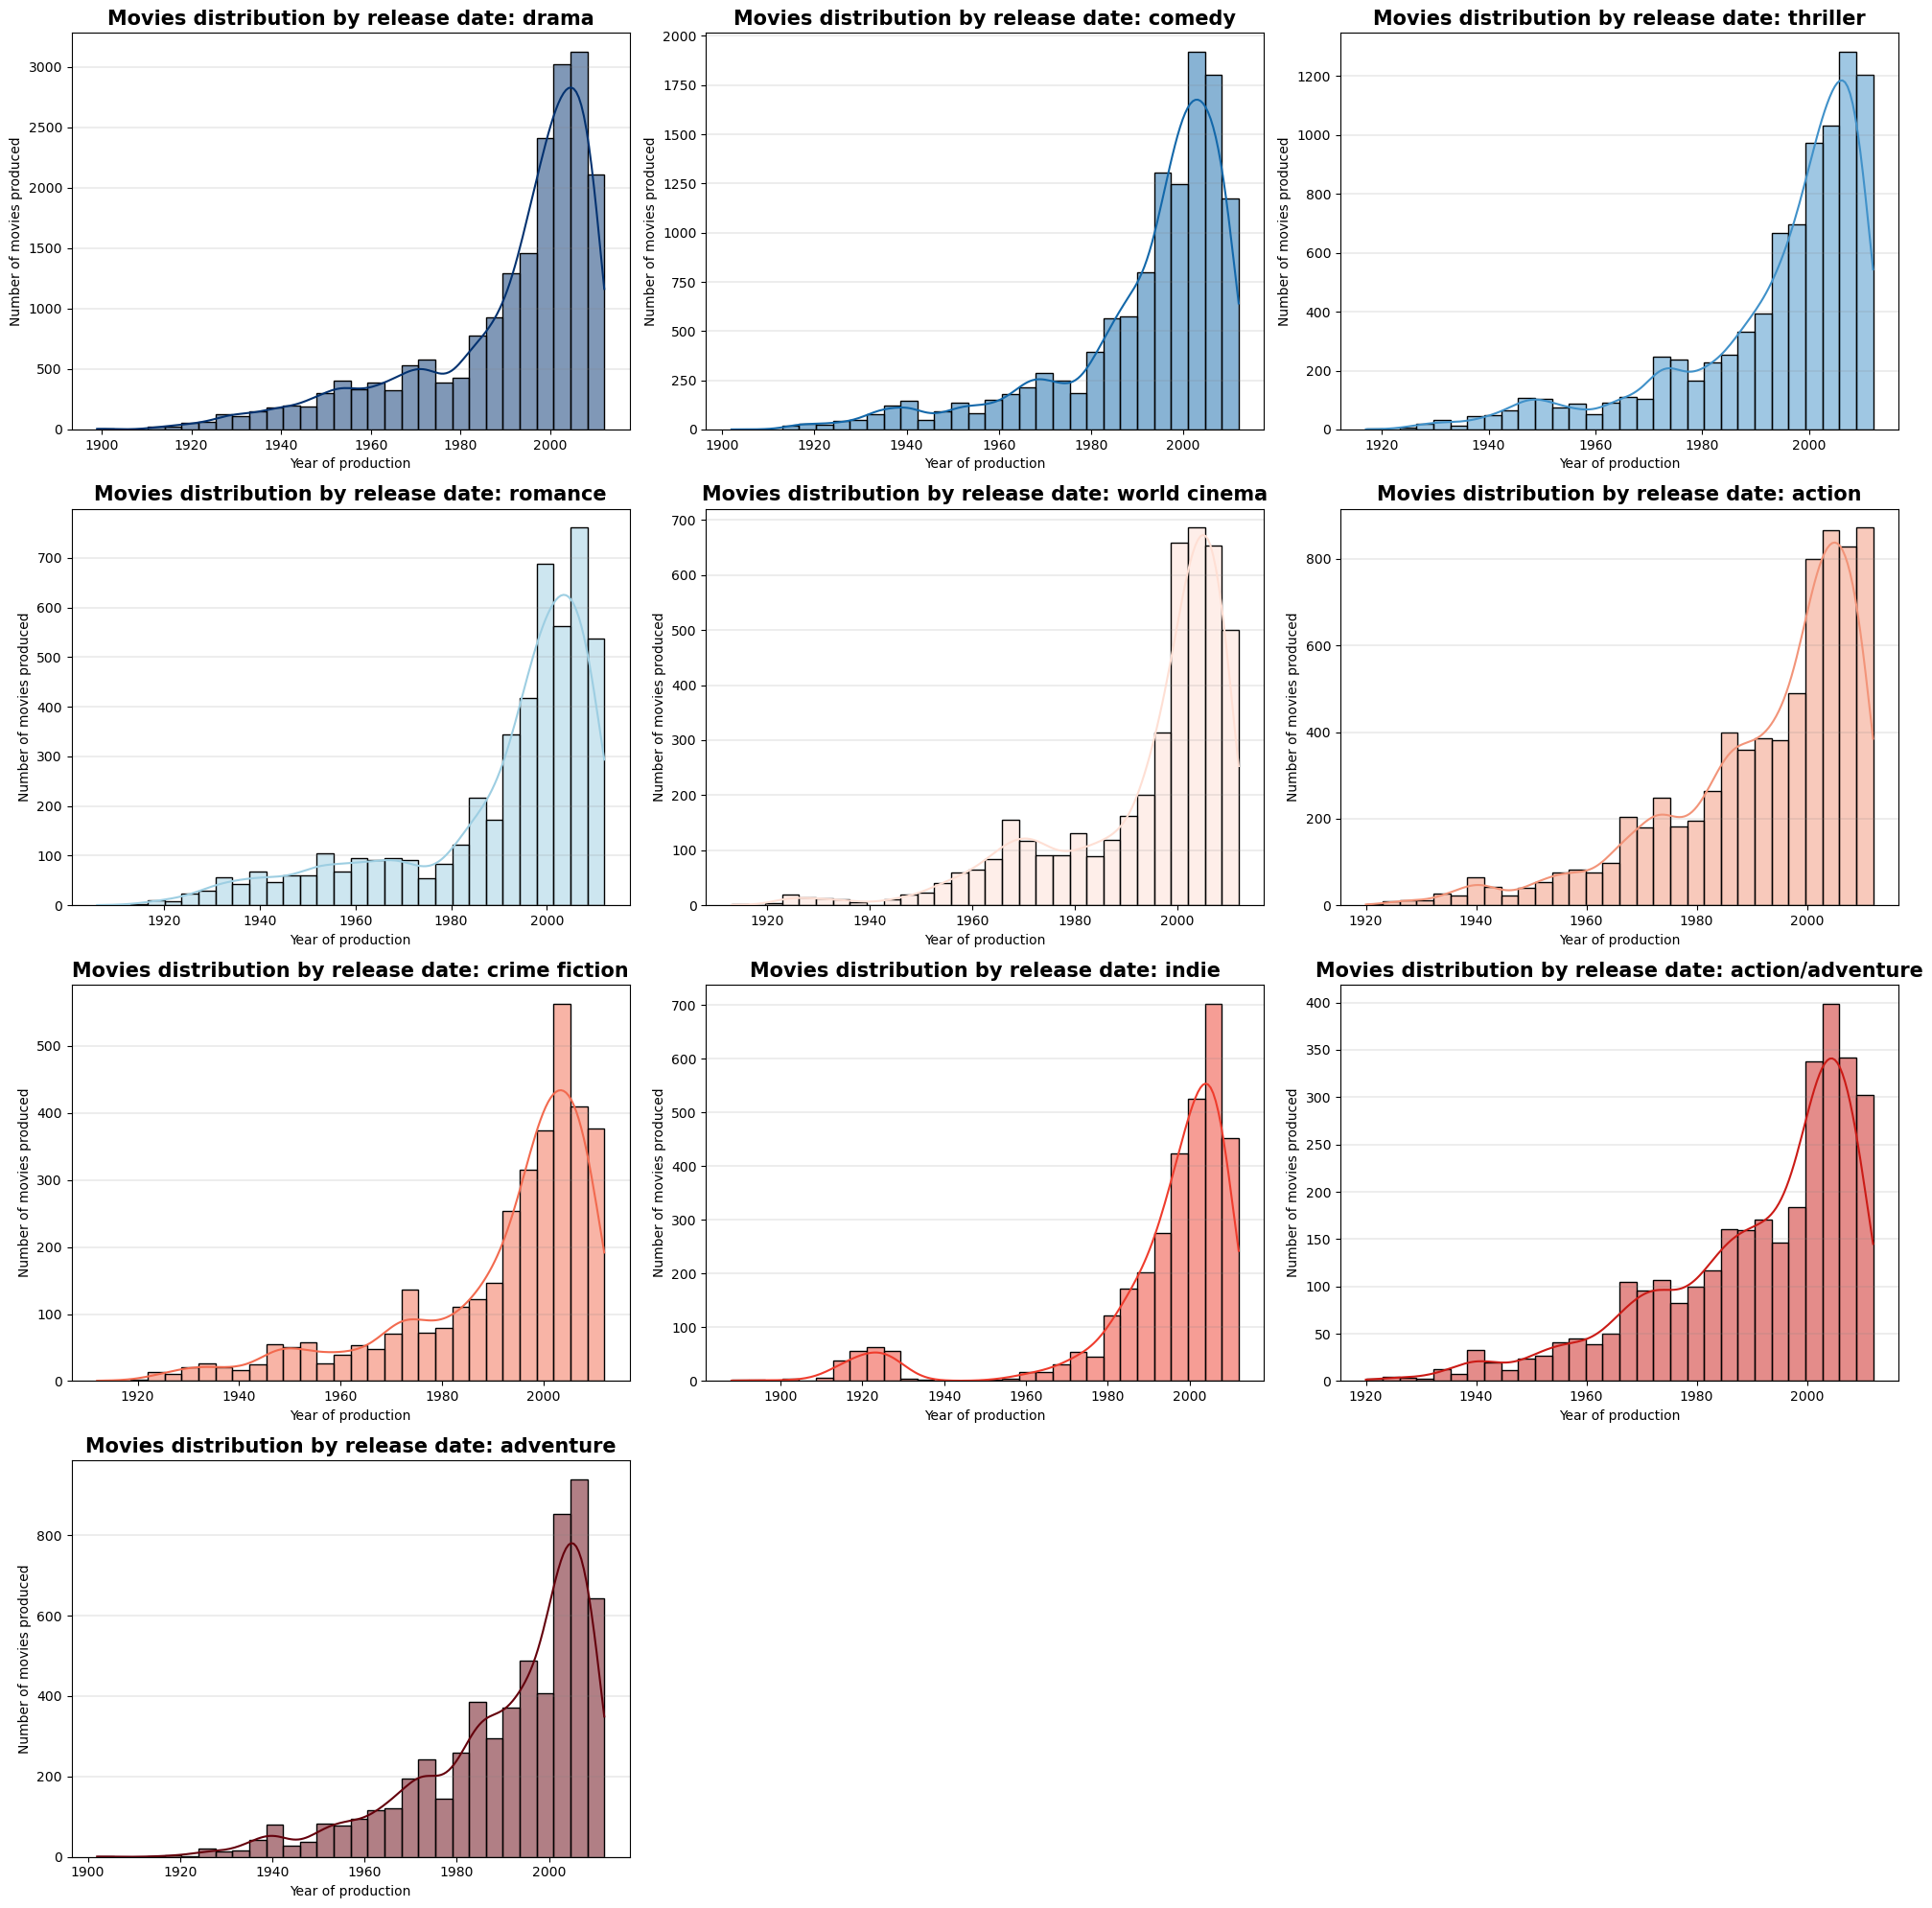

In [38]:
# all plots 
plot_selected_genres(genres_top)

In [39]:
# Choose the number of top genres
n = 10
genres_top = (df_movies_tmdb_ratings['genres']
              .value_counts()
              .head(n)
              .index.tolist())

# Define custom palette
colors = ['#033270','#1368aa', '#4091c9', '#9dcee2','#fedfd4','#f29479','#f26a4f','#ef3c2d','#cb1b16','#65010c' ]
custom_palette = dict(zip(genres_top, colors))

# Dropdown for selecting one genre
genre_selector = SelectMultiple(
    options=genres_top,
    value=genres_top[:1],
    description='Genres',
    disabled=False
)

# Interface
interact(plot_selected_genres, selected_genres=genre_selector)


interactive(children=(SelectMultiple(description='Genres', index=(0,), options=('drama', 'comedy', 'thriller',…

<function __main__.plot_selected_genres(selected_genres)>

In [40]:
'''
# Code to save the graphs in HTML format
import plotly.express as px
import plotly.io as pio
import pandas as pd
import re

# Esempio di dataset di prova (da sostituire con il tuo dataset reale)
# df_movies_tmdb_ratings = pd.read_csv('your_dataset.csv')

# Verifica che le colonne 'genres' e 'release_date' esistano
if 'genres' not in df_movies_tmdb_ratings.columns or 'release_date' not in df_movies_tmdb_ratings.columns:
    raise ValueError("Il dataset deve contenere le colonne 'genres' e 'release_date'.")

# Scegliere il numero di generi principali
n = 10
genres_top = (df_movies_tmdb_ratings['genres']
              .value_counts()
              .head(n)
              .index.tolist())

# Palette personalizzata
colors = ['#033270', '#1368aa', '#4091c9', '#9dcee2', '#fedfd4',
          '#f29479', '#f26a4f', '#ef3c2d', '#cb1b16', '#65010c']
custom_palette = dict(zip(genres_top, colors))

# Funzione per creare e salvare grafici Plotly per ogni genere selezionato
def plot_selected_genres_and_save(genres_list):
    for genre in genres_list:
        # Filtra i film per il genere selezionato
        genre_movies = df_movies_tmdb_ratings[
            df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and genre in x)
        ]
        
        # Rimuove le date nulle
        genre_movies = genre_movies.dropna(subset=['release_date'])
        
        # Colore personalizzato
        hist_color = custom_palette.get(genre, '#4091c9')
        
        # Crea il grafico Plotly
        fig = px.histogram(
            genre_movies, 
            x='release_date', 
            nbins=30,
            title=f'Movies Distribution by Release Date: {genre}',
            color_discrete_sequence=[hist_color]
        )
        
        # Personalizza il layout
        fig.update_layout(
            xaxis_title='Year of Production',
            yaxis_title='Number of Movies Produced',
            bargap=0.1
        )

        # Prepara un nome file valido
        safe_genre = re.sub(r'\W+', '_', genre).lower()
        filename = f"plot_{safe_genre}.html"
        
        # Salva il grafico come file HTML
        pio.write_html(fig, filename)
        print(f"Grafico salvato come {filename}")

# Chiamare la funzione per generare e salvare i grafici
plot_selected_genres_and_save(genres_top)
'''


'\n# Code to save the graphs in HTML format\nimport plotly.express as px\nimport plotly.io as pio\nimport pandas as pd\nimport re\n\n# Esempio di dataset di prova (da sostituire con il tuo dataset reale)\n# df_movies_tmdb_ratings = pd.read_csv(\'your_dataset.csv\')\n\n# Verifica che le colonne \'genres\' e \'release_date\' esistano\nif \'genres\' not in df_movies_tmdb_ratings.columns or \'release_date\' not in df_movies_tmdb_ratings.columns:\n    raise ValueError("Il dataset deve contenere le colonne \'genres\' e \'release_date\'.")\n\n# Scegliere il numero di generi principali\nn = 10\ngenres_top = (df_movies_tmdb_ratings[\'genres\']\n              .value_counts()\n              .head(n)\n              .index.tolist())\n\n# Palette personalizzata\ncolors = [\'#033270\', \'#1368aa\', \'#4091c9\', \'#9dcee2\', \'#fedfd4\',\n          \'#f29479\', \'#f26a4f\', \'#ef3c2d\', \'#cb1b16\', \'#65010c\']\ncustom_palette = dict(zip(genres_top, colors))\n\n# Funzione per creare e salvare grafici

In [41]:
import re

# Funzione per generare il codice HTML del dropdown
def generate_dropdown_html(genres):
    dropdown_html = '<select id="genre-selector">\n'
    for genre in genres:
        # Crea un nome file valido
        safe_genre = re.sub(r'\W+', '_', genre).lower()
        filename = f"plot_{safe_genre}.html"
        # Aggiunge l'opzione al dropdown
        dropdown_html += f'    <option value="{filename}">{genre}</option>\n'
    dropdown_html += '</select>'
    return dropdown_html

# Genera il codice HTML
dropdown_html = generate_dropdown_html(genres_top)

# Stampa il risultato
print(dropdown_html)

# Salva il dropdown in un file HTML (opzionale)
with open('dropdown.html', 'w') as f:
    f.write(dropdown_html)

<select id="genre-selector">
    <option value="plot_drama.html">drama</option>
    <option value="plot_comedy.html">comedy</option>
    <option value="plot_thriller.html">thriller</option>
    <option value="plot_romance.html">romance</option>
    <option value="plot_world_cinema.html">world cinema</option>
    <option value="plot_action.html">action</option>
    <option value="plot_crime_fiction.html">crime fiction</option>
    <option value="plot_indie.html">indie</option>
    <option value="plot_action_adventure.html">action/adventure</option>
    <option value="plot_adventure.html">adventure</option>
</select>


# Continent Map

In [42]:
country_to_iso = {
    'United States of America': 'USA',
    'Israel': 'ISR',
    'Australia': 'AUS',
    'France': 'FRA',
    'Hungary': 'HUN',
    'Netherlands': 'NLD',
    'United Kingdom': 'GBR',
    'New Zealand': 'NZL',
    'South Africa': 'ZAF',
    'Spain': 'ESP',
    'Canada': 'CAN',
    'Romania': 'ROU',
    'Japan': 'JPN',
    'Hong Kong': 'HKG',
    'Germany': 'DEU',
    'West Germany': 'DEU',  # Same as Germany post-reunification
    'Italy': 'ITA',
    'India': 'IND',
    'Belgium': 'BEL',
    'South Korea': 'KOR',
    'Uruguay': 'URY',
    'Argentina': 'ARG',
    'Poland': 'POL',
    'Austria': 'AUT',
    'Brazil': 'BRA',
    'Finland': 'FIN',
    'Norway': 'NOR',
    'Cuba': 'CUB',
    'Ukraine': 'UKR',
    'Taiwan': 'TWN',
    'England': 'GBR',  # Part of the United Kingdom
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Ireland': 'IRL',
    'Mexico': 'MEX',
    'Czechoslovakia': 'CZE',  # Note: split into Czech Republic and Slovakia
    'Estonia': 'EST',
    'Luxembourg': 'LUX',
    'Denmark': 'DNK',
    'Iceland': 'ISL',
    'Iran': 'IRN',
    'Singapore': 'SGP',
    'Lebanon': 'LBN',
    'Czech Republic': 'CZE',
    'Serbia': 'SRB',
    'Scotland': 'GBR',  # Part of the United Kingdom
    'Portugal': 'PRT',
    'Greece': 'GRC',
    'Zimbabwe': 'ZWE',
    'Turkey': 'TUR',
    'Vietnam': 'VNM',
    'Peru': 'PER',
    'Tunisia': 'TUN',
    'Morocco': 'MAR',
    'Slovak Republic': 'SVK',  # Now Slovakia
    'Thailand': 'THA',
    'Kuwait': 'KWT',
    'Puerto Rico': 'PRI',
    'Yugoslavia': 'YUG',  # Former Yugoslavia, no longer exists
    'Georgian SSR': 'GEO',  # Part of the former Soviet Union
    'Mali': 'MLI',
    'Colombia': 'COL',
    'Republic of Macedonia': 'MKD',  # Now North Macedonia
    'Jamaica': 'JAM',
    'Weimar Republic': 'DEU',  # Historical, same as Germany
    'Senegal': 'SEN',
    'Qatar': 'QAT',
    'Bolivia': 'BOL',
    'Monaco': 'MCO',
    'Philippines': 'PHL',
    'Venezuela': 'VEN',
    'Egypt': 'EGY',
    'Chile': 'CHL',
    'Bahamas': 'BHS',
    'Cameroon': 'CMR',
    'German Democratic Republic': 'DEU',  # Historical, same as Germany
    'Bulgaria': 'BGR',
    'United Arab Emirates': 'ARE',
    'Algeria': 'DZA',
    'Malaysia': 'MYS',
    'Palestinian territories': 'PSE',  # Palestinian territories
    'Bosnia and Herzegovina': 'BIH',
    'Bangladesh': 'BGD',
    'Iraq': 'IRQ',
    'Slovakia': 'SVK',
    'Slovenia': 'SVN',
    'Croatia': 'HRV',
    'Burkina Faso': 'BFA',
    'Northern Ireland': 'GBR',  # Part of the United Kingdom
    'Wales': 'GBR',  # Part of the United Kingdom
    'Lithuania': 'LTU',
    'Nepal': 'NPL',
    'Socialist Federal Republic of Yugoslavia': 'YUG',  # Former Yugoslavia
    'Libya': 'LBY',
    'Serbia and Montenegro': 'SCG',  # Former country
    'Indonesia': 'IDN',
    'Haiti': 'HTI',
    'Afghanistan': 'AFG',
    'Mandatory Palestine': 'PSE',  # Palestinian territories
    'Federal Republic of Yugoslavia': 'SCG',  # Former country
    'Isle of Man': 'IMN',
    'Ukrainian SSR': 'UKR',  # Part of the former Soviet Union
    'Kingdom of Great Britain': 'GBR',  # Historical, same as United Kingdom
    'Zambia': 'ZMB',
    'Kenya': 'KEN',
    'Mongolia': 'MNG',
    'Albania': 'ALB',
    'Panama': 'PAN',
    'Aruba': 'ABW',
    'Montenegro': 'MNE',
    'Malta': 'MLT',
    'Democratic Republic of the Congo': 'COD'
}

def plot_world_map(selected_genres):
    if not selected_genres:
        return 
    
    genre = selected_genres
    genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and genre in x)]
    df_world_map = (genre_movies
                    .groupby(['release_date', 'countries', 'region'])
                    .agg({'mean_rating': 'mean'})
                    .reset_index()
                    .rename(columns={'release_date': 'Year', 'countries': 'Country', 'region': 'Region', 'mean_rating': 'Mean Rating'}))

    # Create a full range of years and all genre combinations
    min_year, max_year = df_world_map['Year'].min(), df_world_map['Year'].max()
    all_years = pd.Series(range(min_year, max_year + 1), name='Year')
    all_countries = df_world_map['Country'].unique()
    all_combinations = pd.MultiIndex.from_product([all_years, all_countries], names=['Year', 'Country']).to_frame(index=False)

    # Merge with the existing dataframe and fill missing values
    df_world_map_full = all_combinations.merge(df_world_map, on=['Year', 'Country'], how='left')

    df_world_map_full['Mean Rating'] = df_world_map_full.groupby('Country')['Mean Rating'].ffill().fillna(0)
    df_world_map_full['ISO_alpha'] = df_world_map_full['Country'].map(country_to_iso)

    country_to_region = add_features.map_regions(regions)
    df_world_map_full['Region'] = df_world_map_full['Country'].map(country_to_region)

    df_world_map_full['scaled_mean_rating'] = df_world_map_full['Mean Rating'].apply(
        lambda x: x if x == 0 else (x - df_world_map_full['Mean Rating'].min()) * 100
    )

    df_world_map_filtered = df_world_map_full[df_world_map_full['Mean Rating'] != 0]
    # Creare una heatmap geografica
    fig = px.choropleth(df_world_map_filtered, 
                        locations="ISO_alpha",  
                        color="Mean Rating",  
                        hover_name="Country", 
                        animation_frame="Year",
                        color_continuous_scale="RdBu",  
                        projection="natural earth",
                        range_color=[1.9, 5])

    # Map layout
    fig.update_layout(
        title={'text': 'Mean Rating variation, per Country, over Time',
            'font': {'size': 24, 'family': 'Arial', 'weight': 'bold'}, 
            'x': 0.5,
            'y': 0.95,
            'xanchor':'center',
            'yanchor':'top'},
        geo=dict(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="whitesmoke"),
        width=1000, 
        height=800)

    fig.show()


# Dropdown for selecting one genre
genre_selector = Dropdown(
    options=genres_top,
    value=None,  # Default value
    description='Genres',
    disabled=False
)

# Interface
interact(plot_world_map, selected_genres=genre_selector)


interactive(children=(Dropdown(description='Genres', options=('drama', 'comedy', 'thriller', 'romance', 'world…

<function __main__.plot_world_map(selected_genres)>

I keep the below code just in case I prefer a visualization with points that change in dimension

In [43]:
# dictionary to associate an iso_alpha to each country
from src.data.continents_clusters import regions
from src.utils import add_features

country_to_iso = {
    'United States of America': 'USA',
    'Israel': 'ISR',
    'Australia': 'AUS',
    'France': 'FRA',
    'Hungary': 'HUN',
    'Netherlands': 'NLD',
    'United Kingdom': 'GBR',
    'New Zealand': 'NZL',
    'South Africa': 'ZAF',
    'Spain': 'ESP',
    'Canada': 'CAN',
    'Romania': 'ROU',
    'Japan': 'JPN',
    'Hong Kong': 'HKG',
    'Germany': 'DEU',
    'West Germany': 'DEU',  # Same as Germany post-reunification
    'Italy': 'ITA',
    'India': 'IND',
    'Belgium': 'BEL',
    'South Korea': 'KOR',
    'Uruguay': 'URY',
    'Argentina': 'ARG',
    'Poland': 'POL',
    'Austria': 'AUT',
    'Brazil': 'BRA',
    'Finland': 'FIN',
    'Norway': 'NOR',
    'Cuba': 'CUB',
    'Ukraine': 'UKR',
    'Taiwan': 'TWN',
    'England': 'GBR',  # Part of the United Kingdom
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Ireland': 'IRL',
    'Mexico': 'MEX',
    'Czechoslovakia': 'CZE',  # Note: split into Czech Republic and Slovakia
    'Estonia': 'EST',
    'Luxembourg': 'LUX',
    'Denmark': 'DNK',
    'Iceland': 'ISL',
    'Iran': 'IRN',
    'Singapore': 'SGP',
    'Lebanon': 'LBN',
    'Czech Republic': 'CZE',
    'Serbia': 'SRB',
    'Scotland': 'GBR',  # Part of the United Kingdom
    'Portugal': 'PRT',
    'Greece': 'GRC',
    'Zimbabwe': 'ZWE',
    'Turkey': 'TUR',
    'Vietnam': 'VNM',
    'Peru': 'PER',
    'Tunisia': 'TUN',
    'Morocco': 'MAR',
    'Slovak Republic': 'SVK',  # Now Slovakia
    'Thailand': 'THA',
    'Kuwait': 'KWT',
    'Puerto Rico': 'PRI',
    'Yugoslavia': 'YUG',  # Former Yugoslavia, no longer exists
    'Georgian SSR': 'GEO',  # Part of the former Soviet Union
    'Mali': 'MLI',
    'Colombia': 'COL',
    'Republic of Macedonia': 'MKD',  # Now North Macedonia
    'Jamaica': 'JAM',
    'Weimar Republic': 'DEU',  # Historical, same as Germany
    'Senegal': 'SEN',
    'Qatar': 'QAT',
    'Bolivia': 'BOL',
    'Monaco': 'MCO',
    'Philippines': 'PHL',
    'Venezuela': 'VEN',
    'Egypt': 'EGY',
    'Chile': 'CHL',
    'Bahamas': 'BHS',
    'Cameroon': 'CMR',
    'German Democratic Republic': 'DEU',  # Historical, same as Germany
    'Bulgaria': 'BGR',
    'United Arab Emirates': 'ARE',
    'Algeria': 'DZA',
    'Malaysia': 'MYS',
    'Palestinian territories': 'PSE',  # Palestinian territories
    'Bosnia and Herzegovina': 'BIH',
    'Bangladesh': 'BGD',
    'Iraq': 'IRQ',
    'Slovakia': 'SVK',
    'Slovenia': 'SVN',
    'Croatia': 'HRV',
    'Burkina Faso': 'BFA',
    'Northern Ireland': 'GBR',  # Part of the United Kingdom
    'Wales': 'GBR',  # Part of the United Kingdom
    'Lithuania': 'LTU',
    'Nepal': 'NPL',
    'Socialist Federal Republic of Yugoslavia': 'YUG',  # Former Yugoslavia
    'Libya': 'LBY',
    'Serbia and Montenegro': 'SCG',  # Former country
    'Indonesia': 'IDN',
    'Haiti': 'HTI',
    'Afghanistan': 'AFG',
    'Mandatory Palestine': 'PSE',  # Palestinian territories
    'Federal Republic of Yugoslavia': 'SCG',  # Former country
    'Isle of Man': 'IMN',
    'Ukrainian SSR': 'UKR',  # Part of the former Soviet Union
    'Kingdom of Great Britain': 'GBR',  # Historical, same as United Kingdom
    'Zambia': 'ZMB',
    'Kenya': 'KEN',
    'Mongolia': 'MNG',
    'Albania': 'ALB',
    'Panama': 'PAN',
    'Aruba': 'ABW',
    'Montenegro': 'MNE',
    'Malta': 'MLT',
    'Democratic Republic of the Congo': 'COD'
}


genre = 'drama'
genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and genre in x)]
df_world_map = (genre_movies
                .groupby(['release_date', 'countries', 'region'])
                .agg({'mean_rating': 'mean'})
                .reset_index()
                .rename(columns={'release_date': 'Year', 'countries': 'Country', 'region': 'Region', 'mean_rating': 'Mean Rating'}))

# Create a full range of years and all genre combinations
min_year, max_year = df_world_map['Year'].min(), df_world_map['Year'].max()
all_years = pd.Series(range(min_year, max_year + 1), name='Year')
all_countries = df_world_map['Country'].unique()
all_combinations = pd.MultiIndex.from_product([all_years, all_countries], names=['Year', 'Country']).to_frame(index=False)

# Merge with the existing dataframe and fill missing values
df_world_map_full = all_combinations.merge(df_world_map, on=['Year', 'Country'], how='left')

df_world_map_full['Mean Rating'] = df_world_map_full.groupby('Country')['Mean Rating'].ffill().fillna(0)
df_world_map_full['ISO_alpha'] = df_world_map_full['Country'].map(country_to_iso)

country_to_region = add_features.map_regions(regions)
df_world_map_full['Region'] = df_world_map_full['Country'].map(country_to_region)

df_world_map_full['scaled_mean_rating'] = df_world_map_full['Mean Rating'].apply(
    lambda x: x if x == 0 else (x - df_world_map_full['Mean Rating'].min()) * 100
)

'''fig = px.scatter_geo(df_world_map_full, locations="ISO_alpha", color="Region",
                     hover_name="Country", size="scaled_mean_rating", 
                     animation_frame="Year",
                     projection="natural earth")

# Increase max dimension for better visualization
fig.update_layout(
    width=1600, 
    height=800,
    title="Movie Ratings by Country and Region",
    showlegend=True
)

# Increase points max dimensions 
fig.update_traces(marker=dict(
    sizemin=1,  
    sizemode='area',  
    #sizeref=100
))'''

'fig = px.scatter_geo(df_world_map_full, locations="ISO_alpha", color="Region",\n                     hover_name="Country", size="scaled_mean_rating", \n                     animation_frame="Year",\n                     projection="natural earth")\n\n# Increase max dimension for better visualization\nfig.update_layout(\n    width=1600, \n    height=800,\n    title="Movie Ratings by Country and Region",\n    showlegend=True\n)\n\n# Increase points max dimensions \nfig.update_traces(marker=dict(\n    sizemin=1,  \n    sizemode=\'area\',  \n    #sizeref=100\n))'